# Voting

In [1]:
#1

# Importing the libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import sys
import numpy
numpy.set_printoptions(threshold=sys.maxsize)

# Importing the dataset
dataset = pd.read_csv('CVD dataset-plin-7-9.csv') #διαβάζω το dataset που δεν περιλαμβανει τα features 7 και 9
# dataset = pd.read_csv('CVD dataset2.csv')
data=dataset.iloc[:, :].values
X = dataset.iloc[:, :-1].values
y = dataset.iloc[:, 14].values
# X = dataset.iloc[:, [ 0, 1, 2, 5, 10, 11, 13, 15]].values

rows = len(data)    # 3 rows in your example
cols = len(data[0])
print(rows)
print(cols)

560
15


In [2]:
#2

dataNoCvd = data[~(data[:,14] > 0.0)] #χωρίζω τα data σε 2 πίνακες, ο ένας με τα cvd ο άλλος με τα όχι cvd
dataCvd = data[~(data[:,14] < 1.0)]
rowsNoCvd = len(dataNoCvd)    
rowsCvd = len(dataCvd)
print(rowsNoCvd)
print(rowsCvd)
# print(dataNoCvd)
# print(dataCvd)

519
41


In [3]:
def find_NoCvd_limitsArray(i,DownNoCvd, UpNoCvd, fold_NoCvd_total, fold_NoCvd_residue):
    if i>0 :
        DownNoCvd = UpNoCvd
        UpNoCvd= fold_NoCvd_total+UpNoCvd
    if i < fold_NoCvd_residue :
        UpNoCvd+= 1
#     print("NoCvd limits, Down :",DownNoCvd,"Up ",UpNoCvd)
    return   DownNoCvd, UpNoCvd   
 
def find_Cvd_limitsArray(i,DownCvd, UpCvd, fold_Cvd_total, fold_Cvd_residue,cv):
    if i>0 :
        DownCvd = UpCvd
        UpCvd= fold_Cvd_total+UpCvd
    if i >= cv - fold_Cvd_residue :
         UpCvd+= 1     
#     print("Cvd limits, Down :",DownCvd,"Up ",UpCvd)
    return   DownCvd, UpCvd  

def find_testValSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd):
    temp1=dataNoCvd[DownNoCvd:UpNoCvd,:]
    temp2=dataCvd[DownCvd:UpCvd,:]
    temp3=np.concatenate((temp1, temp2))
#     print(len(temp1),"  ",len(temp2),"  ",len(temp3))
    return temp3

def find_trainSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd):
    temp1 = np.delete(dataNoCvd, slice(DownNoCvd, UpNoCvd), axis=0)
    temp2 = np.delete(dataCvd, slice(DownCvd, UpCvd), axis=0)
    temp3 = np.concatenate((temp1, temp2))
#     print(len(temp1),"  ",len(temp2),"  ",len(temp3))
    return temp1, temp2, temp3

In [4]:
def create_train_test_sets(cv,dataNoCvd,dataCvd,val_ratio):
    # cv= αριθμός των folds, κάνω 10-fold cross validation γιαυτό το έχω θέσει 10
    # val_ratio= το ποσοστό του training set που θα γίνει validation set, το έβαλα 10%
    test_total = []
    train_total = []
    train_total_Cvd = []
    train_total_NoCvd = []
    validation_total = []
    
    #στόχος είναι να χωρίσουμε τα δεδομένα σε 10 folds με ποσοστό instances με cvd περιπου 7%, το 1 fold θα                                
    #χρησιμοποιείται για test και τα άλλα 9 θα ενωνονται και θα χρησιμοποιούνται για train-validation
    
    rowsNoCvd = len(dataNoCvd)    # βρίσκω τον αριθμό των instances χωρίς cvd
    rowsCvd = len(dataCvd)        # βρίσκω τον αριθμό των instances με cvd

    #fold_Cvd_total = αριθμός των instances με cvd που θα μπουν  σίγουρα στο 1 fold = 4
    fold_Cvd_total = rowsCvd//cv 
    #fold_Cvd_residue = το υπόλοιπο των instances που πρέπει να το μοιράσουμε στα 10 folds, δηλαδη κάποια 
    #θα έχουν ένα instance με cvd παραπάνω = 1
    fold_Cvd_residue= rowsCvd%cv
    print("fold_Cvd_total  :",fold_Cvd_total," fold_Cvd_residue  :",fold_Cvd_residue)

    #fold_NoCvd_total = αριθμός των instances χωρίς cvd που θα μπουν  σίγουρα στο 1 fold = 51
    fold_NoCvd_total = rowsNoCvd//cv
    #fold_NoCvd_residue = το υπόλοιπο των instances που πρέπει να το μοιράσουμε στα 10 folds, δηλαδη κάποια 
    #θα έχουν ένα instance χωρίς cvd παραπάνω = 9
    fold_NoCvd_residue= rowsNoCvd%cv
    print("fold_NoCvd_total:",fold_NoCvd_total,"fold_NoCvd_residue:",fold_NoCvd_residue)
    
    #Cvd_val= αριθμός instances με cvd που θα μπει στο validation set,το train set αποτελείται από 504 instances  
    #από αυτά το 7% είναι cvd, εμείς από το 7% θα πάρουμε το 10% για το validatio set
    Cvd_val = round(504*val_ratio*(rowsCvd/len(data)))
    #504*val_ratio= ο συνολικός αριθμός των instances  με του validation set, άρα αν από αυτόν αφαιρέσουμε 
    #το Cvd_val θα πάρουμε των αριθμό των instances χωρίς cvd που θα μπουν στο validation set
    noCvd_val = round(504*val_ratio)-Cvd_val
    print(Cvd_val,noCvd_val)
    
    #dataNoCvd= [0 1 2 .... 517 518] αυτοί είναι οι δείκτες του πίνακα με όλα τα NoCvd instances, τα  DownNoCvd και
    # UpNoCvd θα είναι οι δείκτες στους οποίους θα γίνεται το χώρισμα του πίνακα dataNoCvd κάθε φορά προκειμένου
    # να πάρουμε ένα fold, DownNoCvd=κάτω όριο, UpNoCvd= πάνω όριο, ξεκινάμε με DownNoCvd=0(από την αρχή του πίνακα)
    # UpNoCvd = fold_NoCvd_total(αριθμός NoCvd instances που θα μπουν σίγουρα στο fold)
    #
    #dataCvd= [0 1 2.. 39 40] δείκτες του πίνακα dataCvd, με την ίδια λογική με πριν DownCvd=0=κάτω όριο-δείκτης
    # UpCvd= άνω όριο-δείκτης=fold_Cvd_total(αριθμός Cvd instances που θα μπουν σίγουρα στο fold)
    DownNoCvd=0
    DownCvd=0
    UpNoCvd = fold_NoCvd_total
    UpCvd = fold_Cvd_total
    #τα όρια αυτά θα αλλάξουν 10 φορές, όσα είναι και τα fold 
    
    for i in range(cv):
        X_test = []
        y_test = []
        X_train = []
        y_train = []
        X_val = []
        y_val = []
        
        #find_NoCvd_limitsArray = βρίσκει τα όρια του dataNoCvd πίνακα για το i fold
        DownNoCvd, UpNoCvd = find_NoCvd_limitsArray(i, DownNoCvd, UpNoCvd, fold_NoCvd_total, fold_NoCvd_residue)
        #find_Cvd_limitsArray = βρίσκει τα όρια του dataCvd πίνακα για το i fold
        DownCvd, UpCvd = find_Cvd_limitsArray(i, DownCvd, UpCvd, fold_Cvd_total, fold_Cvd_residue,cv)

        testSubset_total = find_testValSubset(DownNoCvd,UpNoCvd,DownCvd,UpCvd)
        if i!=9:
#             print(UpNoCvd,UpNoCvd+noCvd_val,UpCvd,UpCvd+Cvd_val)
            validationSubset_total = find_testValSubset(UpNoCvd,UpNoCvd+noCvd_val,UpCvd,UpCvd+Cvd_val)
#             print(DownNoCvd,UpNoCvd+noCvd_val,DownCvd,UpCvd+Cvd_val)
            trainSubset_NoCvd ,trainSubset_Cvd ,trainSubset_total = find_trainSubset(DownNoCvd,UpNoCvd+noCvd_val,DownCvd,UpCvd+Cvd_val)
        else:
#             print(DownNoCvd-noCvd_val,DownNoCvd,DownCvd-Cvd_val,DownCvd)
            validationSubset_total = find_testValSubset(DownNoCvd-noCvd_val,DownNoCvd,DownCvd-Cvd_val,DownCvd)
#             print(DownNoCvd-noCvd_val,UpNoCvd,DownCvd-Cvd_val,UpCvd)
            trainSubset_NoCvd ,trainSubset_Cvd ,trainSubset_total = find_trainSubset(DownNoCvd-noCvd_val,UpNoCvd,DownCvd-Cvd_val,UpCvd)
    #creating X_train, y_train, X_test, y_test
        X_test.append(np.delete(testSubset_total, 14, axis=1))
        y_test_temp = np.delete(testSubset_total, slice(0, 14), axis=1)
        y_test.append(np.reshape(y_test_temp, len(y_test_temp)))
        X_test_temp = np.array(X_test)
        X_test = X_test_temp[0]
        y_test_temp = np.array(y_test)
        y_test = y_test_temp[0]
        
        X_val.append(np.delete(validationSubset_total, 14, axis=1))
        y_val_temp = np.delete(validationSubset_total, slice(0, 14), axis=1)
        y_val.append(np.reshape(y_val_temp, len(y_val_temp)))
        X_val_temp = np.array(X_val)
        X_val = X_val_temp[0]
        y_val_temp = np.array(y_val)
        y_val = y_val_temp[0]
        
        X_train.append(np.delete(trainSubset_total, 14, axis=1))
        y_train_temp = np.delete(trainSubset_total, slice(0, 14), axis=1)
        y_train.append(np.reshape(y_train_temp, len(y_train_temp)))
        X_train_temp = np.array(X_train)
        X_train = X_train_temp[0]
        y_train_temp = np.array(y_train)
        y_train = y_train_temp[0]
        
    #add every subset in a list so we can handle thm later 
        test_total.append([X_test,y_test])
        validation_total.append([X_val,y_val])
        train_total.append([X_train,y_train]) 
        train_total_NoCvd.append(trainSubset_NoCvd)
        train_total_Cvd.append(trainSubset_Cvd)
    return train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd

In [5]:
#3 

#η create_train_test_sets 
train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd = create_train_test_sets(10,dataNoCvd,dataCvd,0.1)

fold_Cvd_total  : 4  fold_Cvd_residue  : 1
fold_NoCvd_total: 51 fold_NoCvd_residue: 9
4 46


In [6]:
# Chech ratio in each train and test set
def find_ratio(index_list):
    one = 0
    lenght=len(index_list[0])
    for i in range(lenght):
#         print(index_list[1])
        if index_list[1][i] == 1.0 :
            one+= 1
    ratio = one/lenght
    return ratio

for i in range(10):
    print(len(train_total[i][0]))
    ratio = find_ratio(train_total[i])
    print("ratio in train set:", ratio)
    ratio = find_ratio(test_total[i])
    print("ratio in test set:", ratio)
    ratio = find_ratio(validation_total[i])
    print("ratio in validation set:", ratio)

454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in validation set: 0.08
454
ratio in train set: 0.07268722466960352
ratio in test set: 0.07142857142857142
ratio in vali

In [17]:
from xgboost import XGBClassifier
from xgboost import plot_tree
import matplotlib.pyplot as plt

def my_fit(ratio,dataNoCvd,dataCvd, validation_total, params):   
    Subarray=[]
    models = []
    # yarray
    
    rowsNoCvd = len(dataNoCvd)    
    rowsCvd = len(dataCvd)
#     print("Size of NoCvd cases in train set:",rowsNoCvd)
#     print("Size of Cvd cases in train set  :",rowsCvd)


    numOfSubsamples = rowsNoCvd//(rowsCvd*ratio)
    numOfSubsamples= int(numOfSubsamples)
    SubNoCvd = rowsNoCvd//numOfSubsamples
    residue = rowsNoCvd- SubNoCvd*numOfSubsamples


    Up = 0
    valid_preds = []

    for i in range(numOfSubsamples):
        classifier = XGBClassifier(base_score=params[11], booster='gbtree', colsample_bylevel=params[5],
                  colsample_bynode=params[12], colsample_bytree=params[8], gamma=params[4],
                  learning_rate=params[0], max_delta_step=params[13], max_depth=params[1],
                  min_child_weight=params[3], missing=None, n_estimators=params[2], n_jobs=1,
                  nthread=None, objective='binary:logistic', random_state=0,
                  reg_alpha=params[9], reg_lambda=params[6], scale_pos_weight=params[7], seed=None,
                  silent=None, subsample=params[10], verbosity=1)
    #     print(i)
    #Creating the training set for each model
        Down = Up
        Up= Up + SubNoCvd
        if i < residue :
            Up+= 1
        
#         print(Down)
#         print(Up)
        
        Sub1=dataNoCvd[Down:Up,:]
        Sub2=np.concatenate((Sub1, dataCvd))
        Subarray.append(Sub2)
        
    #Dividing to X and y of the previous traing set    
        X=np.delete(Subarray[i], 14, axis=1)
        y=np.delete(Subarray[i], slice(0, 14), axis=1)
        y=np.reshape(y, len(y))
        
        X_val = validation_total[i][0]
        y_val = validation_total[i][1]
        
        eval_set  = [(X,y), (X_val,y_val)]
        
        classifier.fit( X, y, eval_set=eval_set, eval_metric="auc", early_stopping_rounds=50,verbose = False )
#         classifier.fit( X, y)
        auc_valid = roc_auc_score(y_val, classifier.predict(X_val))
#         print(auc_valid)
        valid_preds.append(auc_valid)
#         plot_tree(classifier)
        
#         plt.rcParams["figure.figsize"] = (40,7)
#         plot_tree(classifier, num_trees=0, rankdir='LR')
#         plt.show()
        models.append(classifier)
    return models,valid_preds

In [8]:
def voting(models,X,auc_valid):
    y_pred = []
    y_pred_models = []
    
    models_size = len(models)
    X_size = len(X)
            
    for i in range(models_size):
        y_pred_models.append(models[i].predict(X))
       
        
    for j in range(X_size):
        case = 0
        for i in range(models_size):
            if y_pred_models[i][j] == 1.0:
                case+=1
        if case >  models_size/2 :
            y_pred.append(1.) 
        else:
            y_pred.append(0.) 
            
    return y_pred  

In [10]:
# https://www.youtube.com/watch?v=Iaxblazgb1Y

def voting(models,X,auc_valid):
    y_pred = []
    y_pred_models = []
    sum_auc = 0
    
    models_size = len(models)
    X_size = len(X)
            
    for i in range(models_size):
        y_pred_models.append(models[i].predict(X))
        sum_auc += auc_valid[i]
       
    for j in range(X_size):
        case = 0
        for i in range(models_size):
            case += y_pred_models[i][j]*(auc_valid[i]/sum_auc)*100
                
        if case >  57.6 :
            y_pred.append(1.) 
        else:
            y_pred.append(0.) 
            
    return y_pred  

In [181]:
# def voting(models,X):
#     y_pred = []
#     y_pred_models = []

#     models_size = len(models)
#     X_size = len(X)
            
#     for i in range(models_size):
#         y_pred_models.append(models[i].predict_proba(X)[:,1])
        
#     for j in range(X_size):
#         case = 0
#         for i in range(models_size):
#             if y_pred_models[i][j] >= 0.499:
#                 case+=1
#         if case >  models_size/2 :
#             y_pred.append(1.) 
#         else:
#             y_pred.append(0.) 
            
#     return y_pred  

In [18]:
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6
#https://statinfer.com/204-4-2-calculating-sensitivity-and-specificity-in-python/

from sklearn.metrics import  confusion_matrix,roc_curve, roc_auc_score, accuracy_score
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import StratifiedKFold # import KFold
from sklearn import metrics

def my_cross_val( cv, train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd,params):
    accuracy = []
    specificity = []
    sensitivity = []
    auc = []
    
    # print(X)
    for i in range(cv):
#         X_train = train_total[i][0]
#         y_train = train_total[i][1]
        X_test = test_total[i][0]
        y_test = test_total[i][1]
        


        models,auc_valid = my_fit( 2, train_total_NoCvd[i], train_total_Cvd[i], validation_total,params)

#         print(auc_valid)

        y_pred = voting(models,X_test,auc_valid)

        cm = confusion_matrix(y_test, y_pred)
    #     print(cm)

        total1=sum(sum(cm))
        #####from confusion matrix calculate accuracy
        accuracy1=(cm[0,0]+cm[1,1])/total1
#         accuracy1=accuracy_score(y_test, y_pred)
    #   print ('Accuracy : ', accuracy1)
#         print ('Accuracy : ', accuracy_score(y_test, y_pred))

        specificity1 = cm[0,0]/(cm[0,0]+cm[0,1])
    #   print('Specificity : ', specificity1 )

        sensitivity1 = cm[1,1]/(cm[1,0]+cm[1,1])
    #   print('Sensitivity : ', sensitivity1)
        
#         y = np.array(y_test)
#         pred = np.array(y_pred)
#         fpr, tpr, thresholds = metrics.roc_curve(y, pred, pos_label=2)
#         auc1 = metrics.auc(fpr, tpr)
        
        auc1 = roc_auc_score(y_test, y_pred)

    
        accuracy.append(accuracy1)
        specificity.append(specificity1)
        sensitivity.append(sensitivity1) 
        auc.append(auc1)
    return accuracy, specificity, sensitivity, auc

In [10]:
comb = compute_comb(params)
print(comb[0])
accuracy, specificity, sensitivity, auc = my_cross_val( 10, train_total, test_total, train_total_NoCvd, train_total_Cvd,comb[0])

NameError: name 'compute_comb' is not defined

In [11]:
from statistics import mean
print(mean(accuracy))
print(mean(specificity))
print(mean(sensitivity))
print(mean(auc))

NameError: name 'accuracy' is not defined

In [19]:
# https://www.geeksforgeeks.org/python-all-possible-permutations-of-n-lists/

def compute_comb(params):
    
    # initializing lists 
    list1 = params.get("learning_rate")
    list2 = params.get("max_depth")
    list3 = params.get("n_estimators") 
    list4 = params.get("min_child_weight")
    list5 = params.get("gamma")    
    list6 = params.get("colsample_bylevel")
    list7 = params.get("reg_lambda") 
    list8 = params.get("scale_pos_weight")
    list9 = params.get("colsample_bytree")
    list10 = params.get("reg_alpha")
    list11 = params.get("subsample")
    list12 = params.get("base_score")
    list13 = params.get("colsample_bynode")
    list14 = params.get("max_delta_step")
    

#     # printing lists  
#     print ("The original lists are : " + str(list1) +
#                                    " " + str(list2) + 
#                                    " " + str(list3) + 
#                                    " " + str(list4) + 
#                                    " " + str(list5) + 
#                                    " " + str(list6) +
#                                    " " + str(list7) +
#                                    " " + str(list8)) 

    # using list comprehension  
    # to compute all possible permutations 
    res = [[i, j, k, l, m, n, o, p,q,r,s,t, u, v] for i in list1  
                                                  for j in list2 
                                                  for k in list3 
                                                  for l in list4 
                                                  for m in list5 
                                                  for n in list6 
                                                  for o in list7
                                                  for p in list8
                                                  for q in list9
                                                  for r in list10
                                                  for s in list11
                                                  for t in list12
                                                  for u in list13
                                                  for v in list14] 

    # printing result 
#     print ("All possible permutations are : " +  str(res))
    return res

In [13]:
class style:
    BOLD = '\033[1m'
    END = '\033[0m'

In [14]:
# https://towardsdatascience.com/train-test-split-and-cross-validation-in-python-80b61beca4b6

from sklearn.metrics import  confusion_matrix,roc_curve, roc_auc_score, accuracy_score
from imxgboost.imbalance_xgb import imbalance_xgboost as imb_xgb
from sklearn.model_selection import StratifiedKFold # import KFold
from statistics import mean

def gridsearch(params):
    max_sens = 0
    max_spes = 0
    max_acc = 0
    best_params = []
    max_params = []
    max_auc = 0
    combs = compute_comb(params)
    print(len(combs))
    for j in range(len(combs)):
        print(j)
        accuracy, specificity, sensitivity, auc = my_cross_val( 10, train_total, test_total, validation_total, train_total_NoCvd, train_total_Cvd,combs[j])
        if mean(auc)>0.65:
            print(style.BOLD + "----------------------------------------------------------------"+ style.END)
            print(combs[j])
            print (style.BOLD + 'accuracy    ' + style.END, mean(accuracy))
            print (style.BOLD + 'specificity ' + style.END, mean(specificity))
            print (style.BOLD + 'sensitivity ' + style.END, mean(sensitivity))
            print (style.BOLD + 'auc         ' + style.END, mean(auc))
            print(style.BOLD + "----------------------------------------------------------------"+ style.END)
        else:
            print(combs[j])
            print("accuracy    ",mean(accuracy))
            print("specificity ",mean(specificity))
            print("sensitivity ",mean(sensitivity))
            print("auc         ",mean(auc))
            
        best_params.append([combs[j],mean(accuracy),mean(specificity),mean(sensitivity),mean(auc)])
        if mean(auc)> max_auc:
            max_sens = mean(sensitivity)
            max_spes = mean(specificity)
            max_acc = mean(accuracy)
            max_auc = mean(auc)
            max_params = combs[j]
    return max_sens, max_params, max_spes, max_acc, max_auc, best_params

# Ratio = 2

 Αποτέλεσμα της gridsearch με τις ακόλουθες παραμέτρους, γίνονται print όλα και αυτά που ικανοποιούν την συνθήκη : if mean(sensitivity)> 0.5 and mean(specificity)>0.6 and mean(accuracy)>0.6 and mean(auc)>0.5 είναι με bold και μεταξύ γραμμών.

In [15]:
# https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/        

params = {
                    "learning_rate"    :[0.3],  #0.01-0.2 Makes the model more robust by shrinking the weights on each step
                    "max_depth"        :[3],  #3-10 control over-fitting as higher depth will allow model to learn relations very specific to a particular sample
                    "n_estimators"     :[1000],
                    "min_child_weight" :[1],         #0.5-1 small values might lead to under-fitting
                    "gamma"            :[1],            #Makes the algorithm conservative --> No overfitting
                    "colsample_bylevel" :[0.75], #0.5-1
                     "reg_lambda"      :[2], #  it should be explored to reduce overfitting.
                    "scale_pos_weight" :[3],
                    "colsample_bytree" :[0.5],
                    "colsample_bynode" :[0.2],
                    "subsample"        :[0.8]
    
        }
# new features [3, 14, 13, 11, 15, 1, 2, 12, 10, 5, 6, 8, 0, 4]
# [0.3, 3, 1000, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8]
# accuracy     0.725
# specificity  0.7245852187028657
# sensitivity  0.735
# auc          0.7297926093514329

1
0


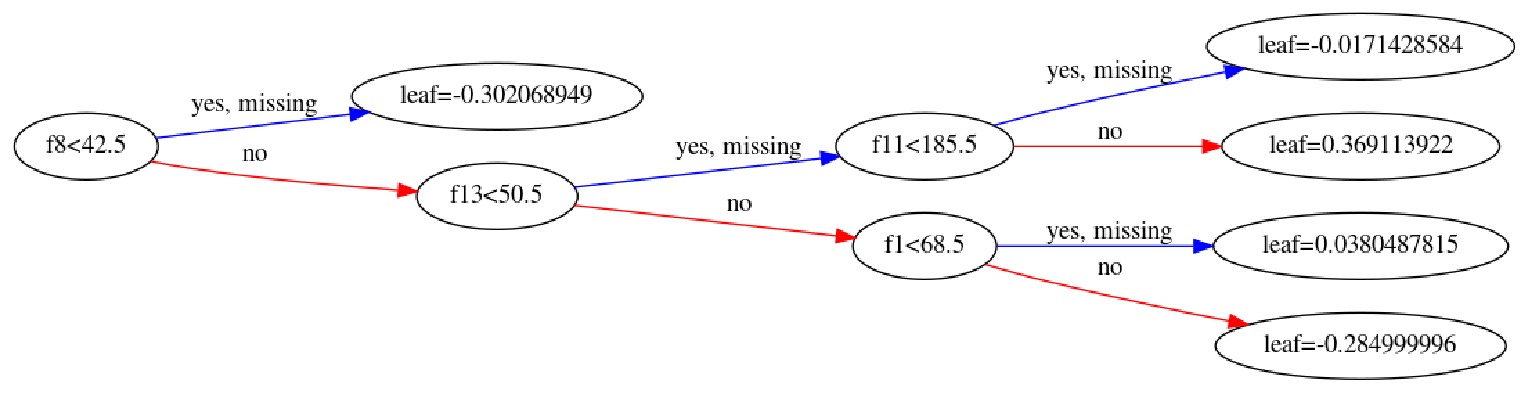

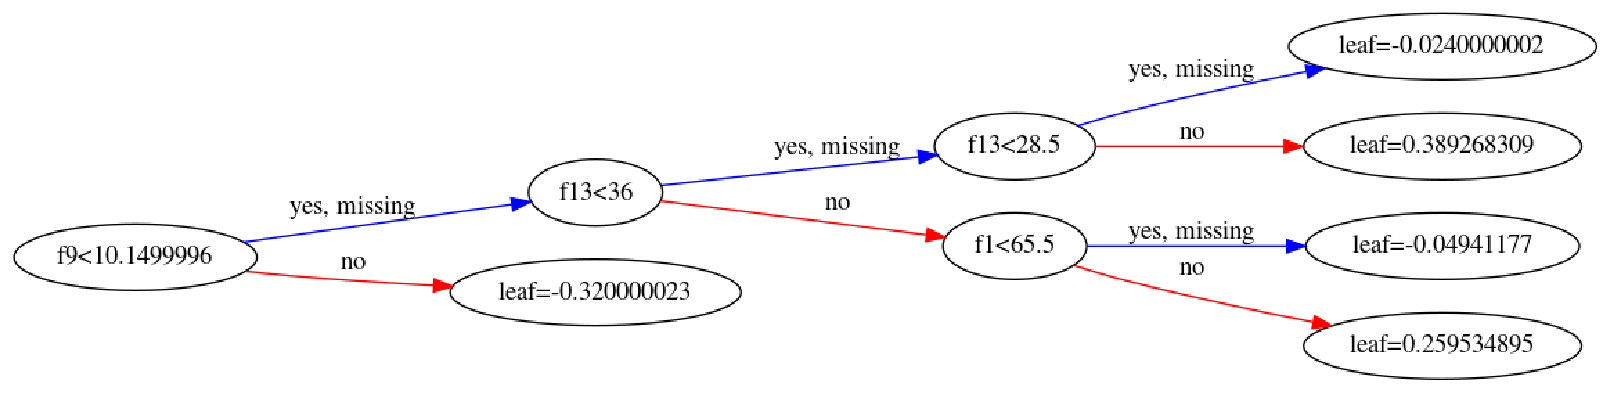

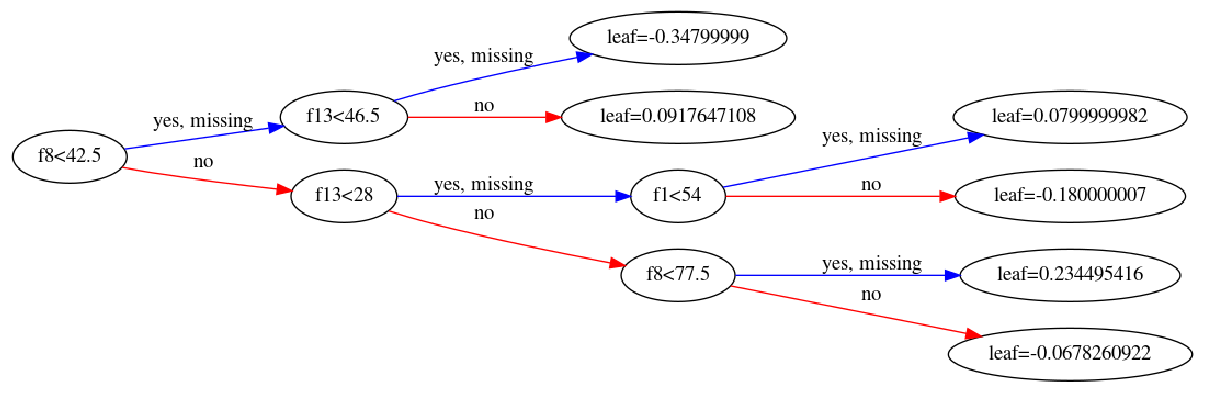

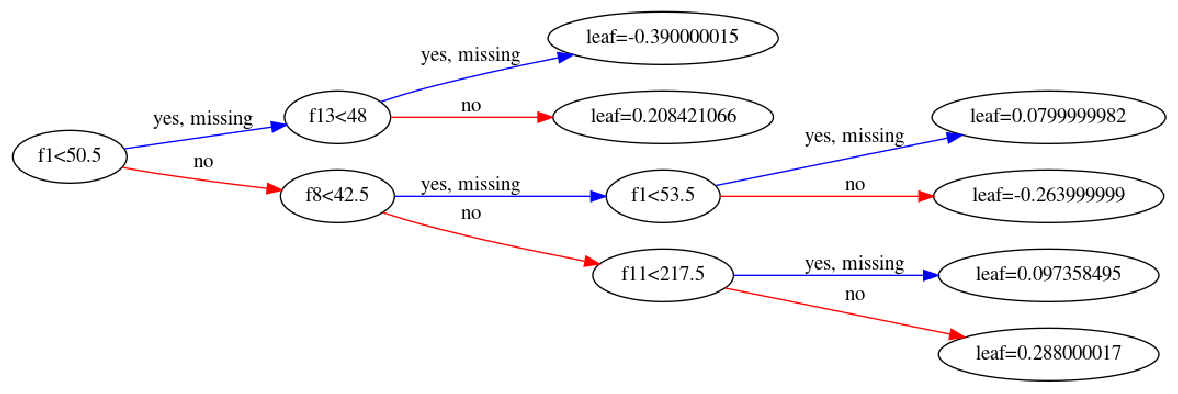

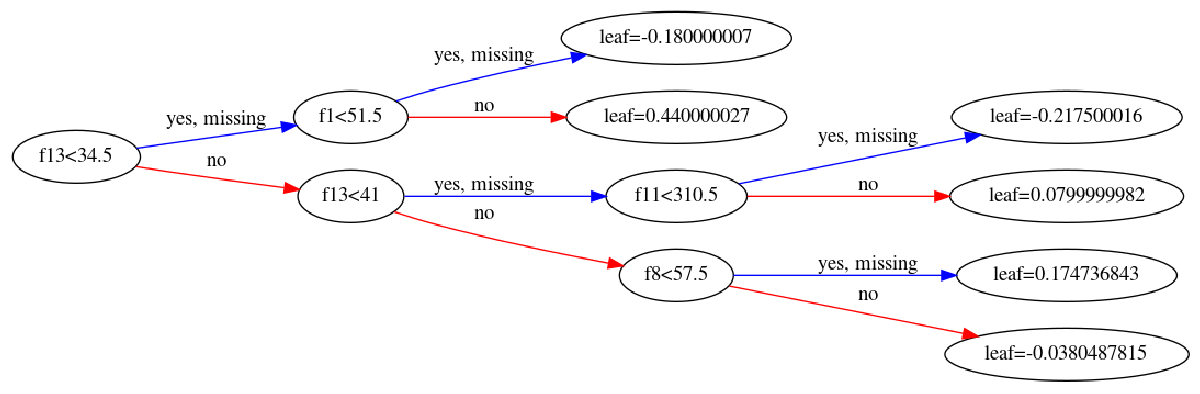

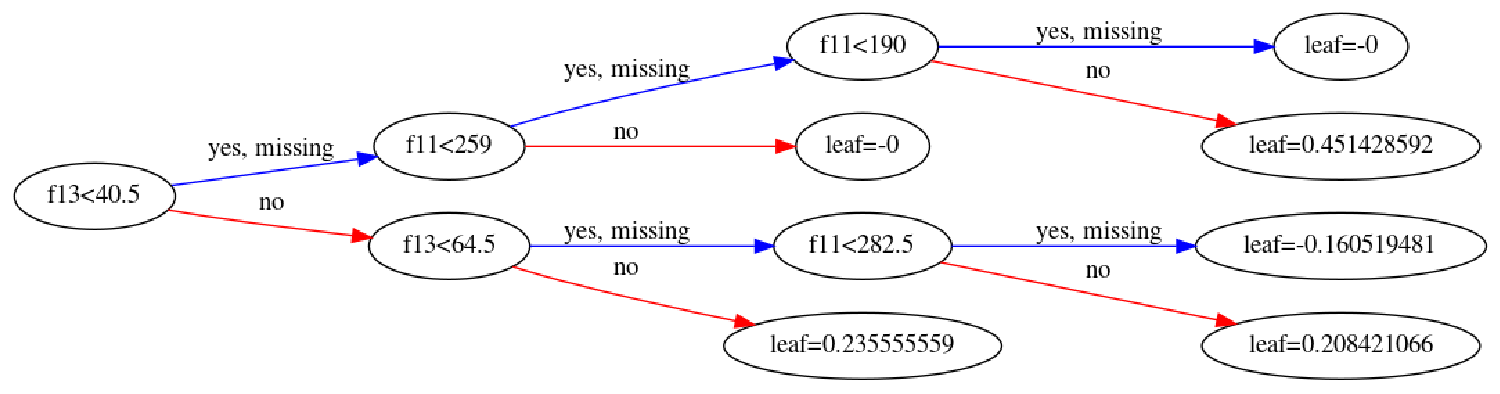

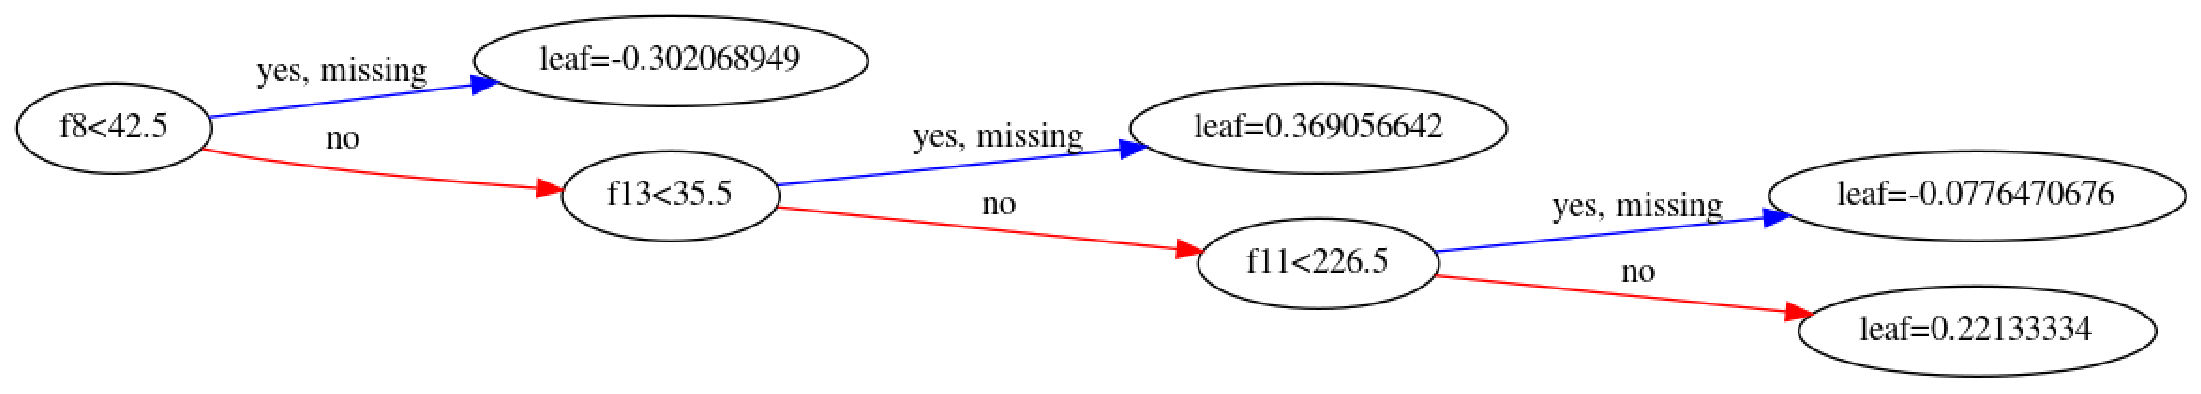

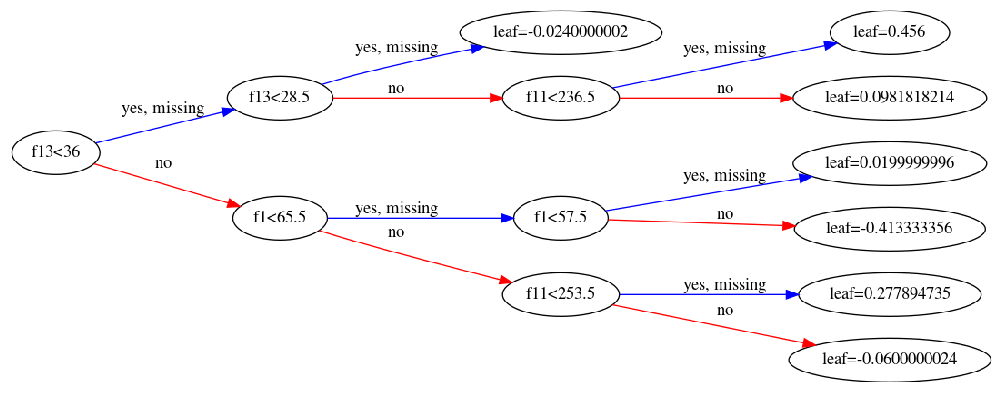

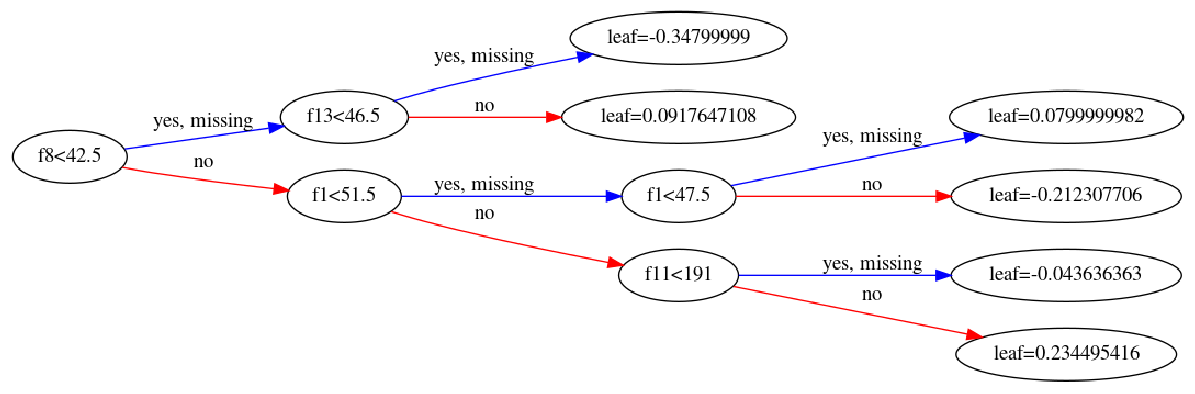

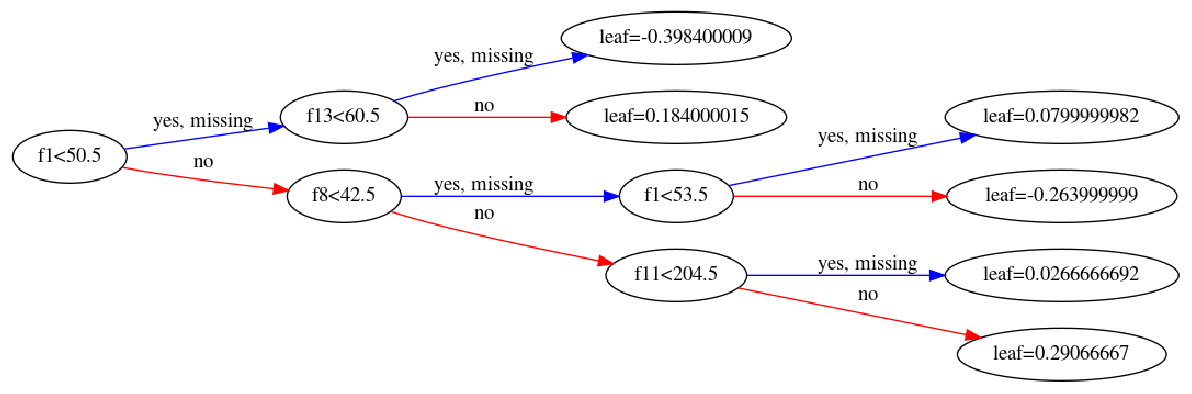

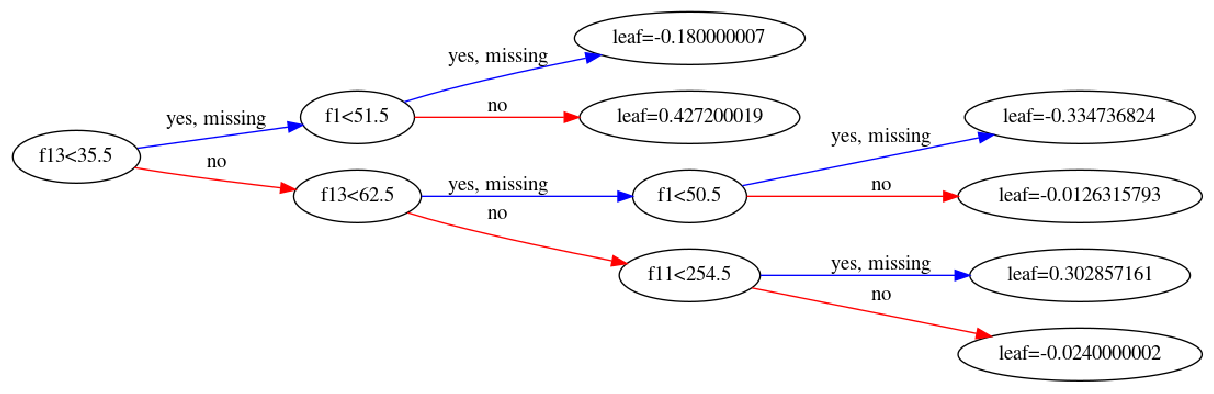

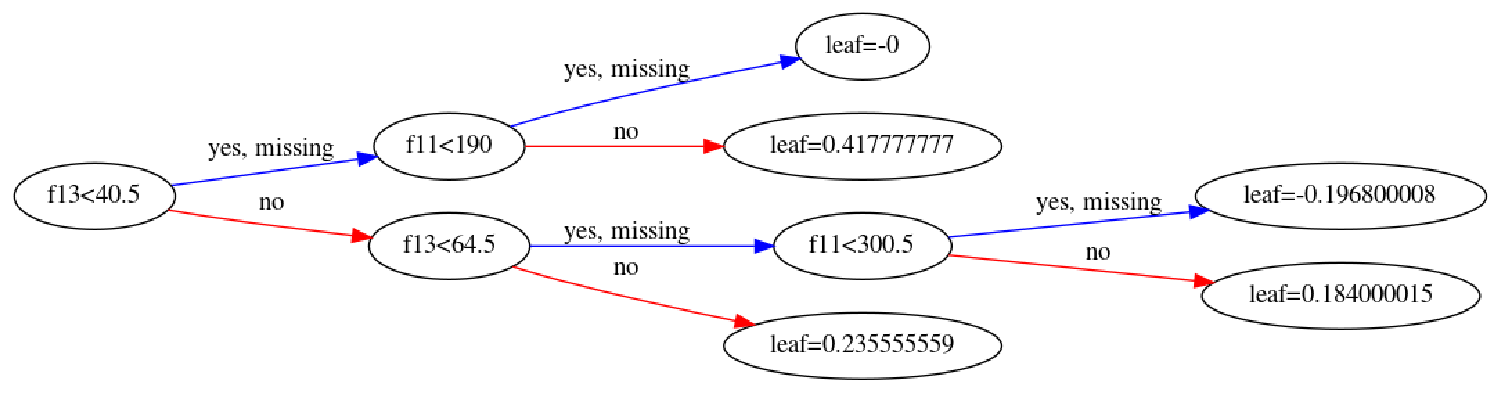

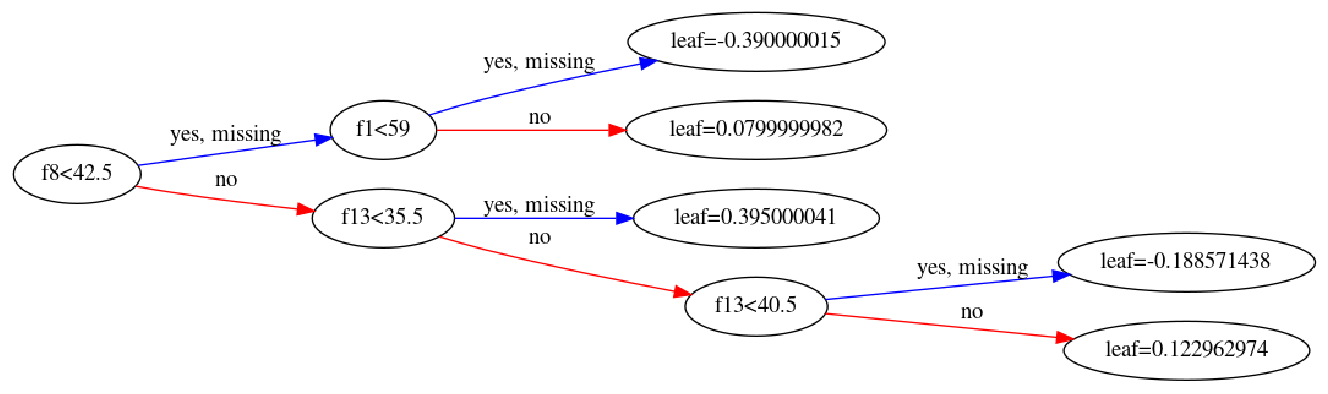

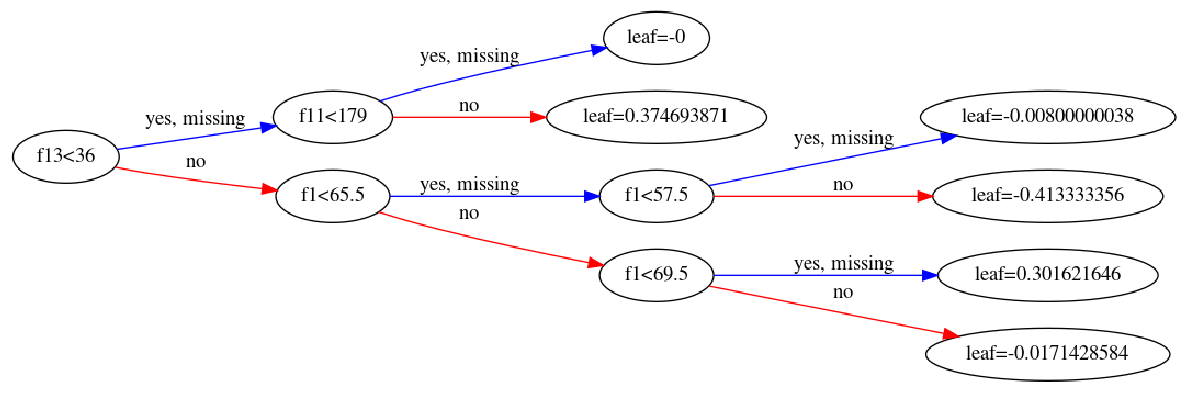

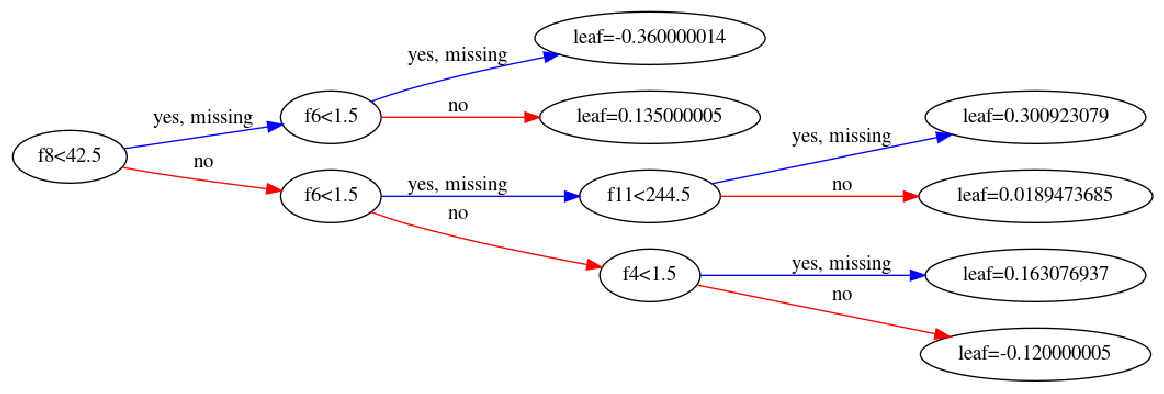

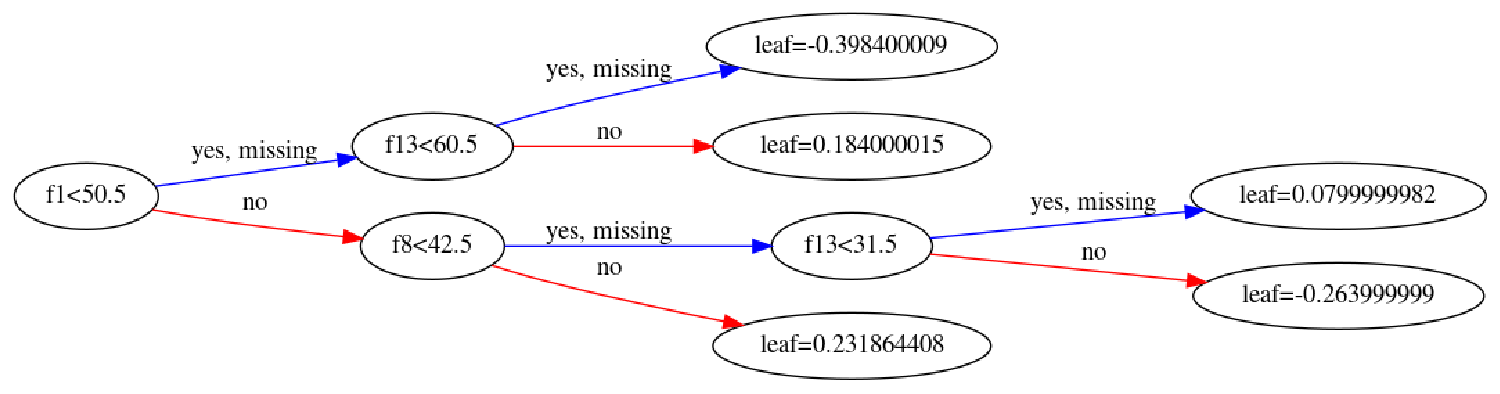

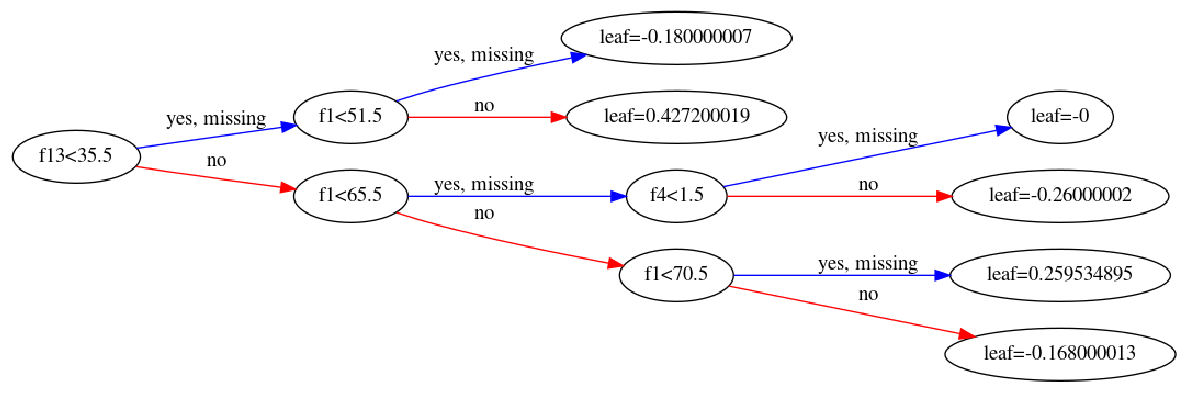

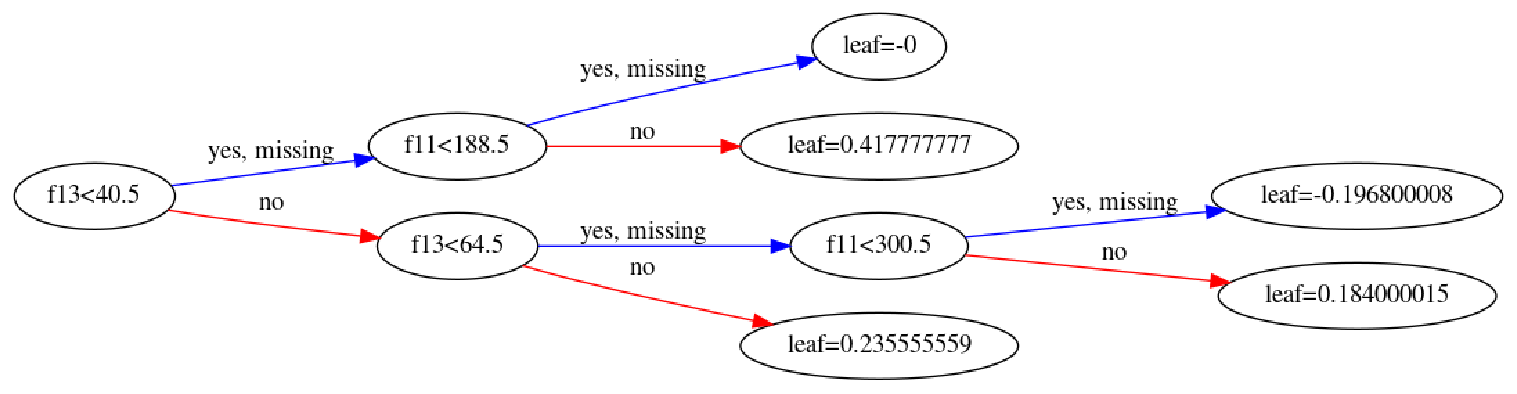

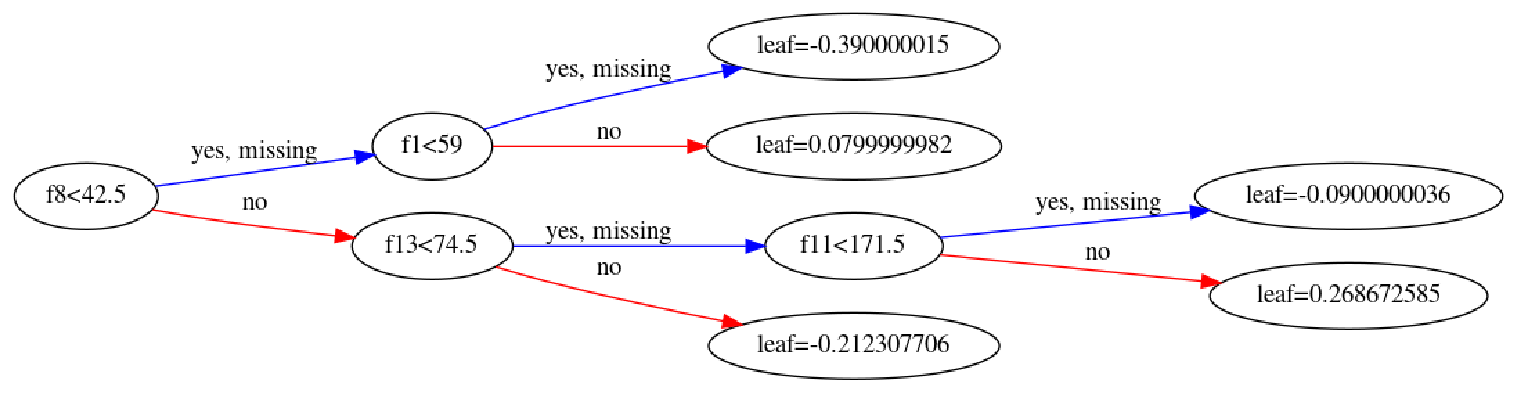

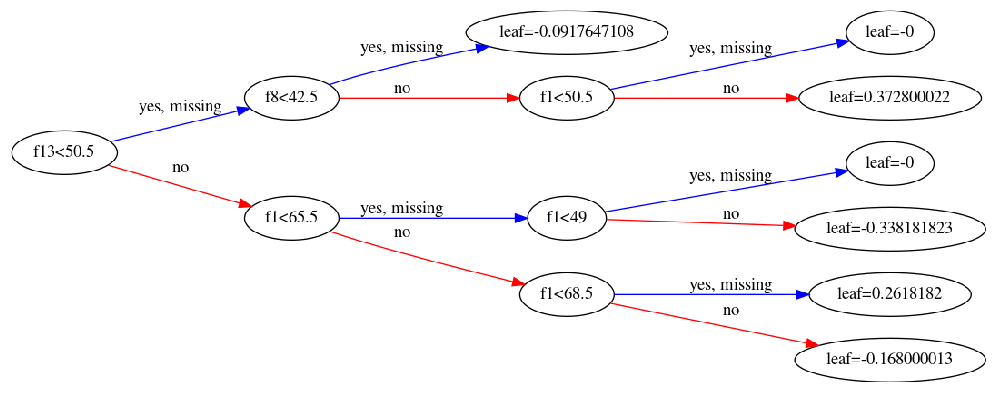

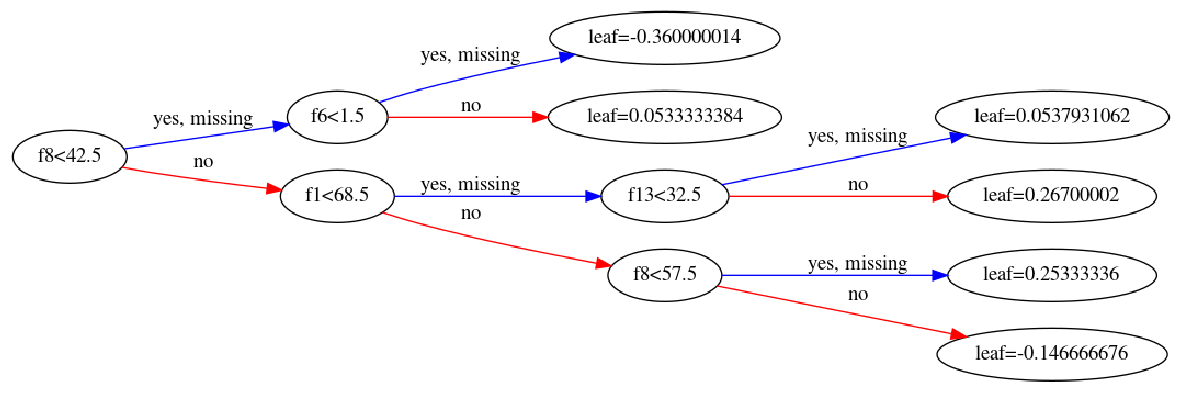

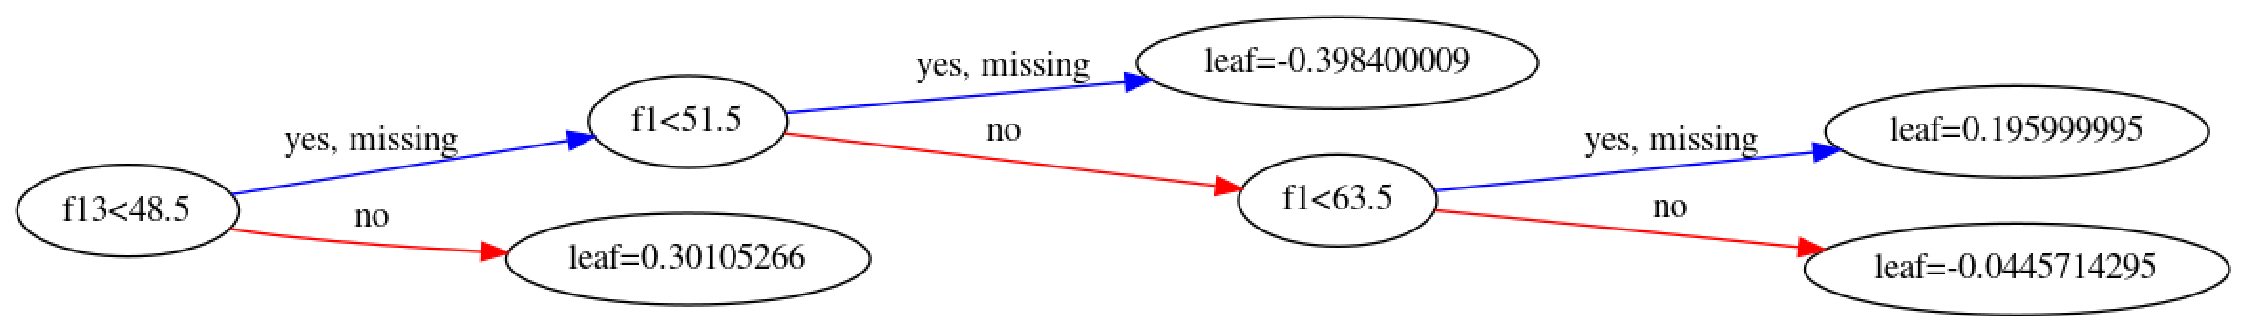

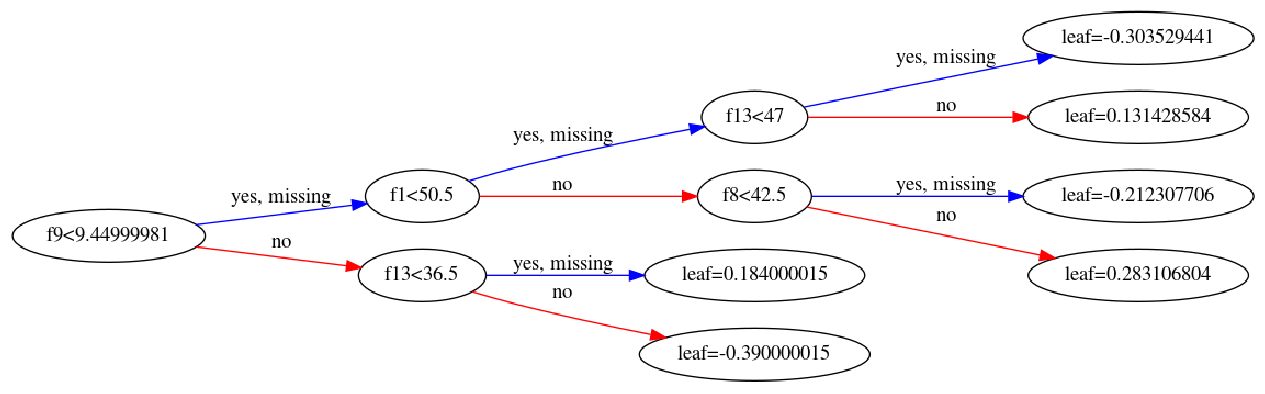

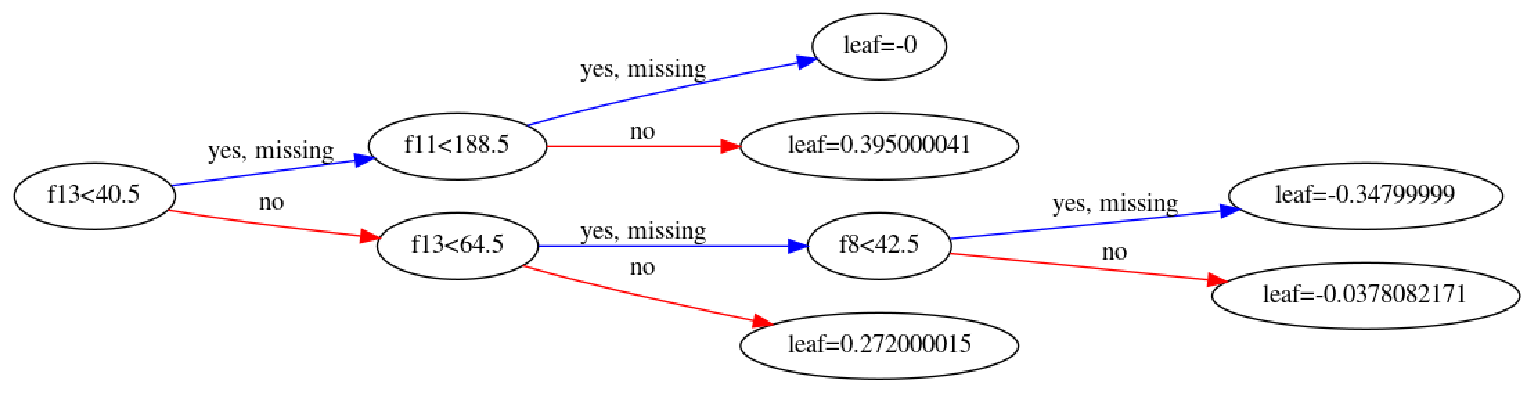

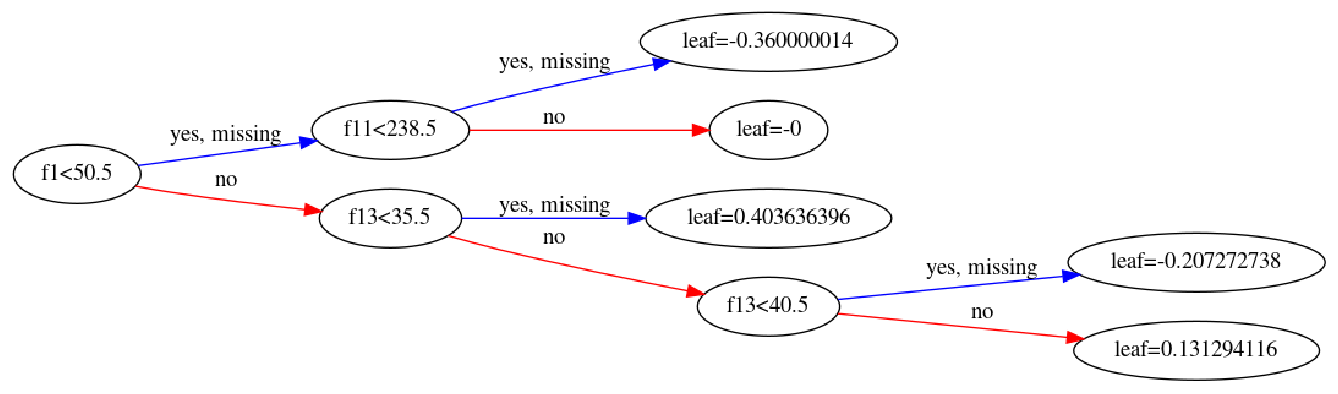

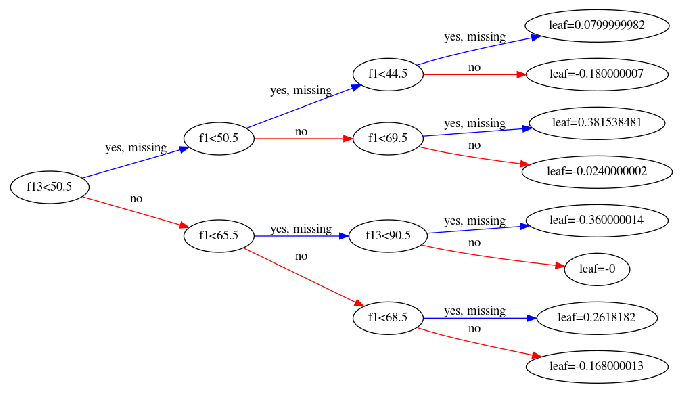

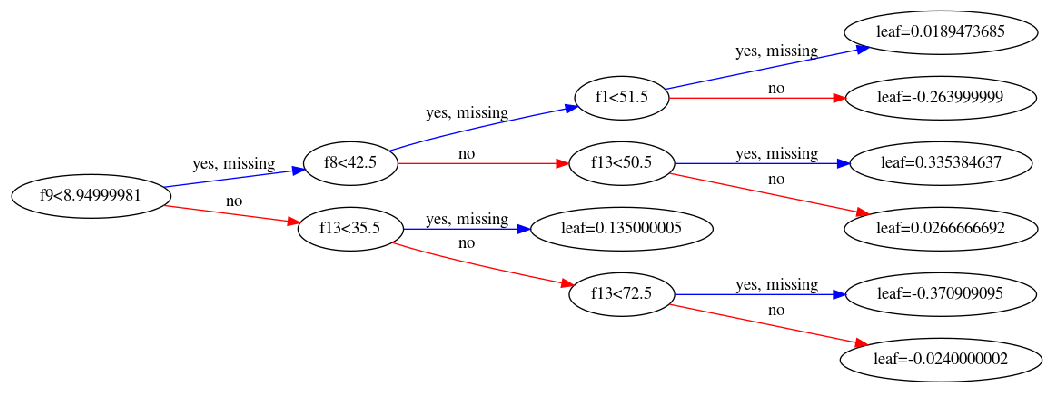

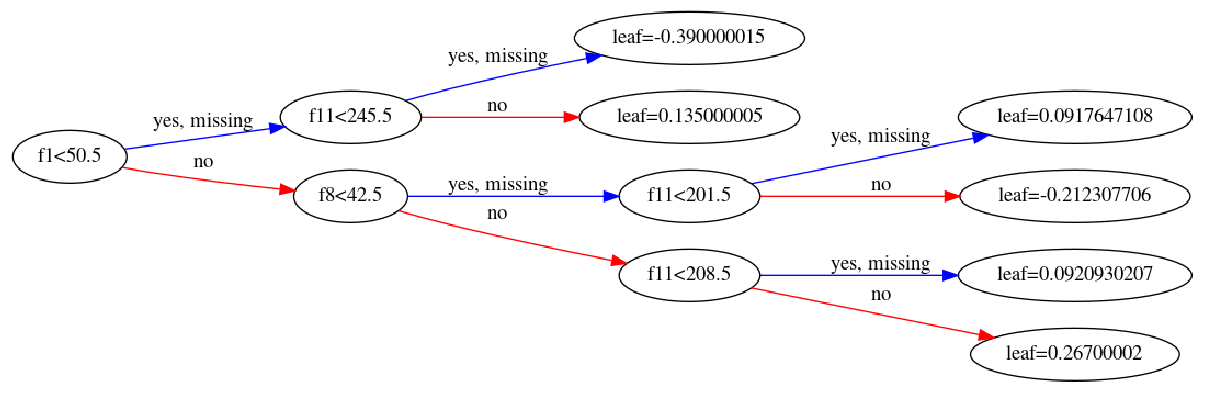

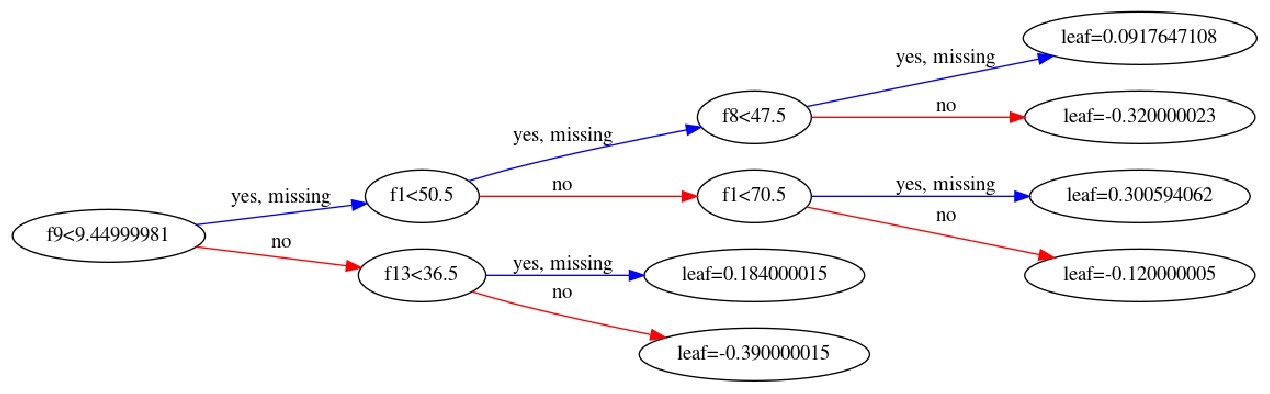

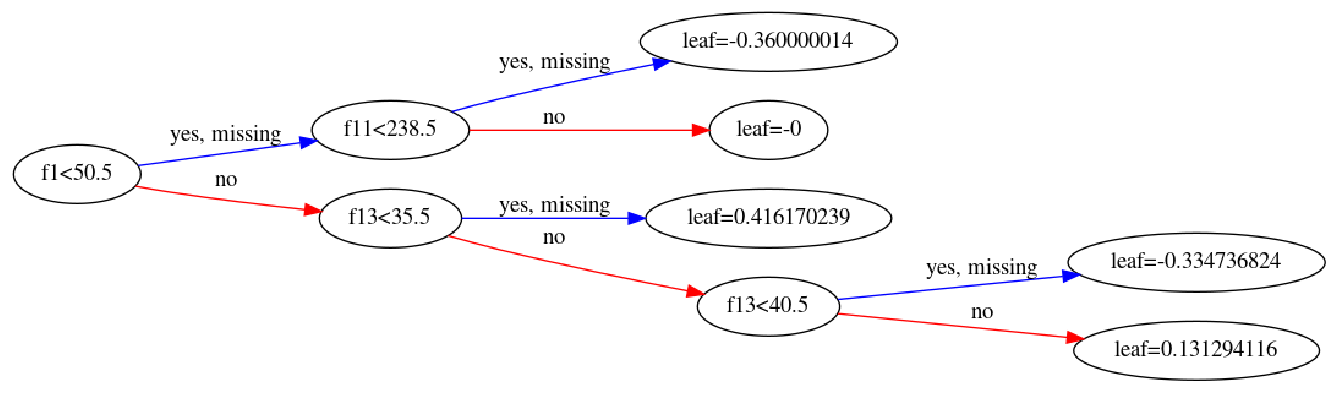

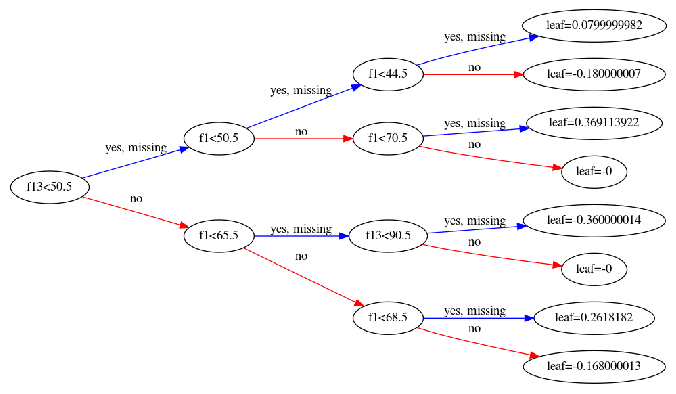

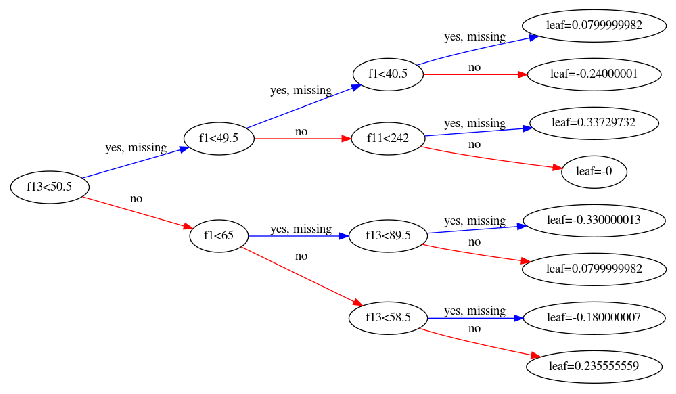

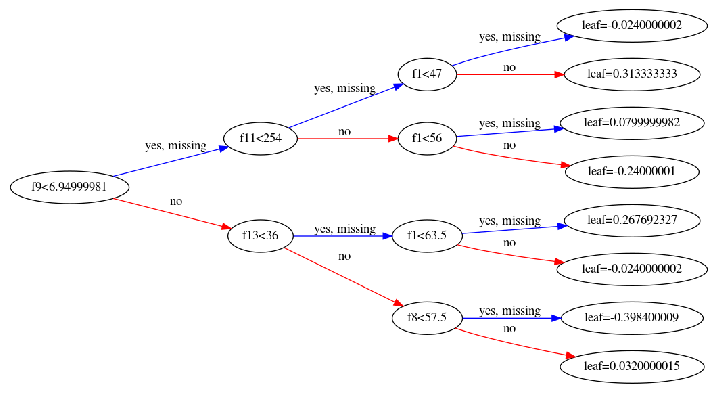

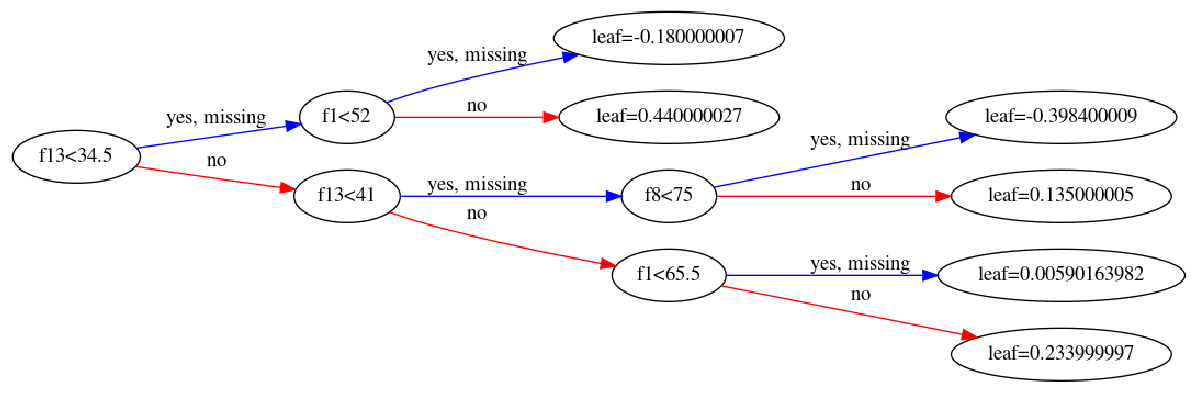

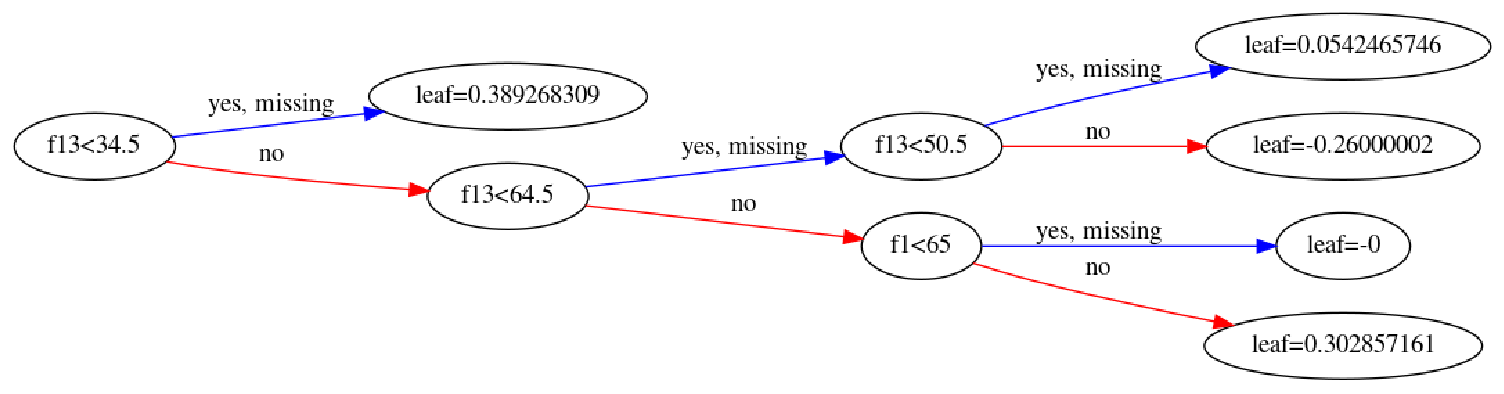

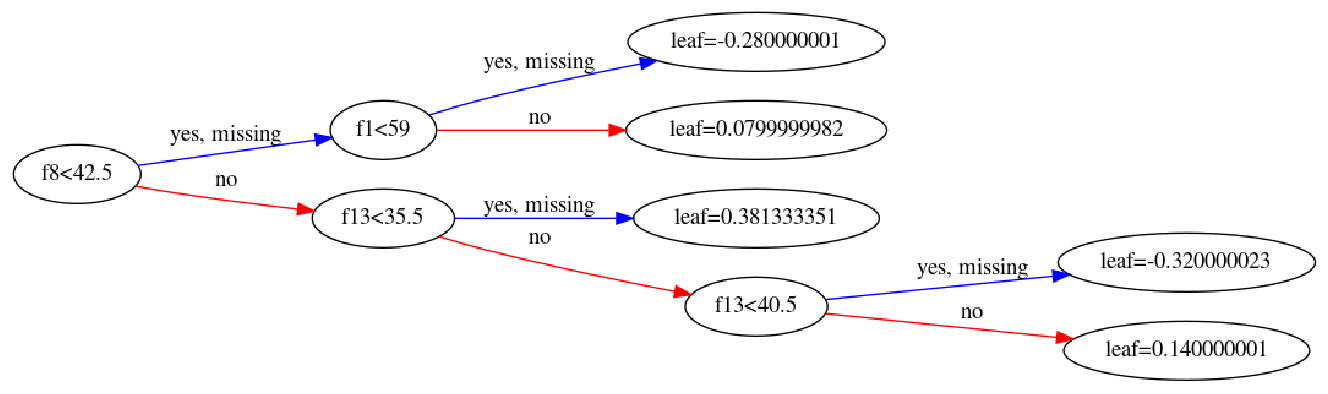

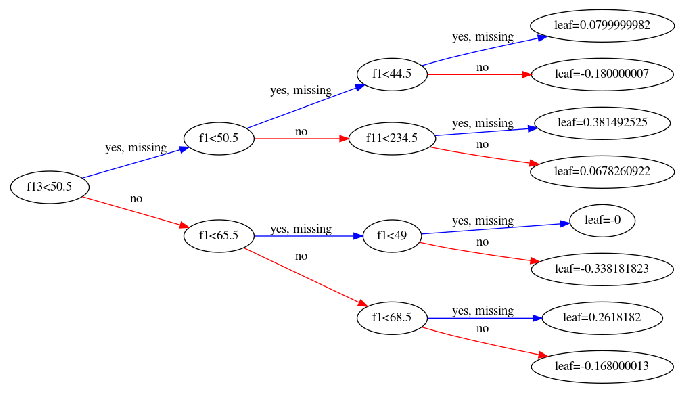

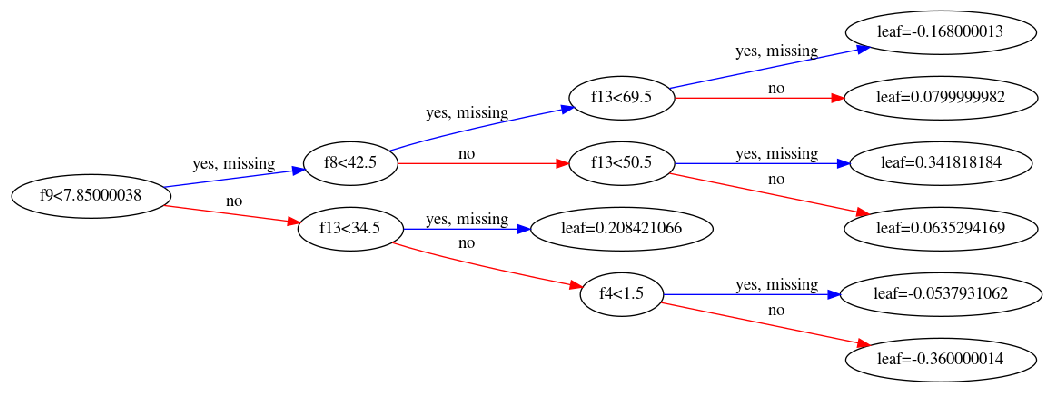

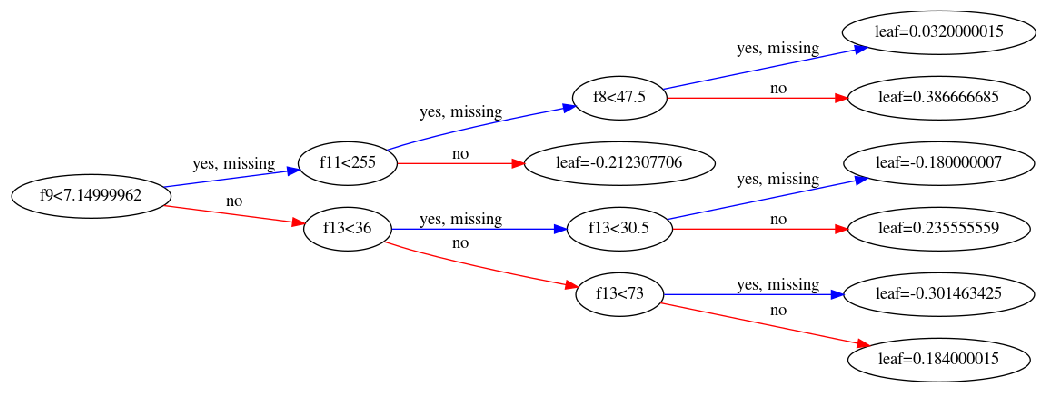

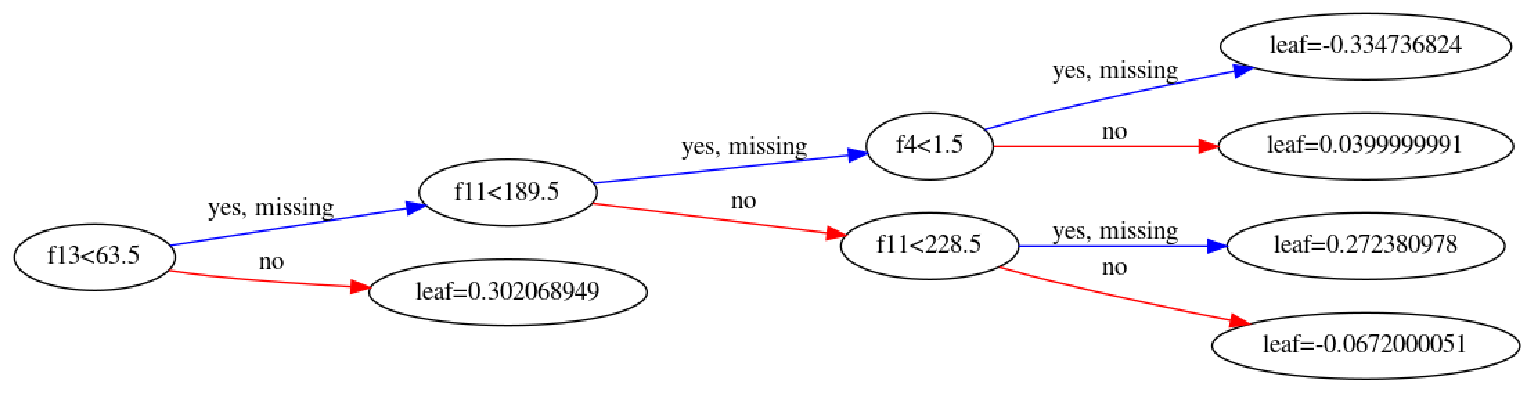

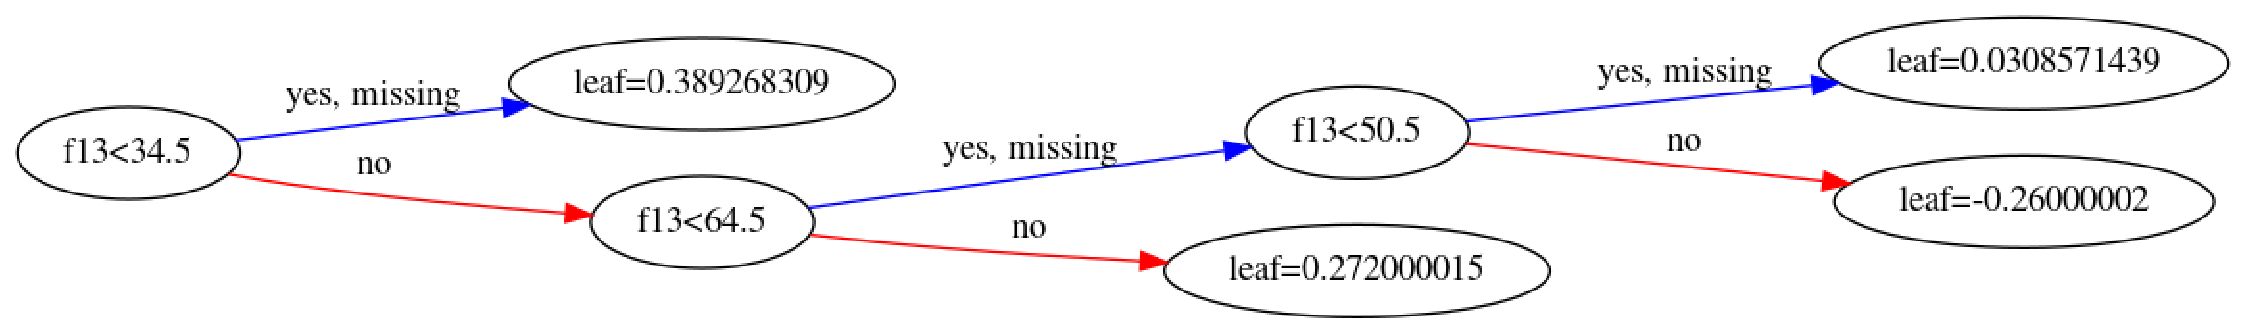

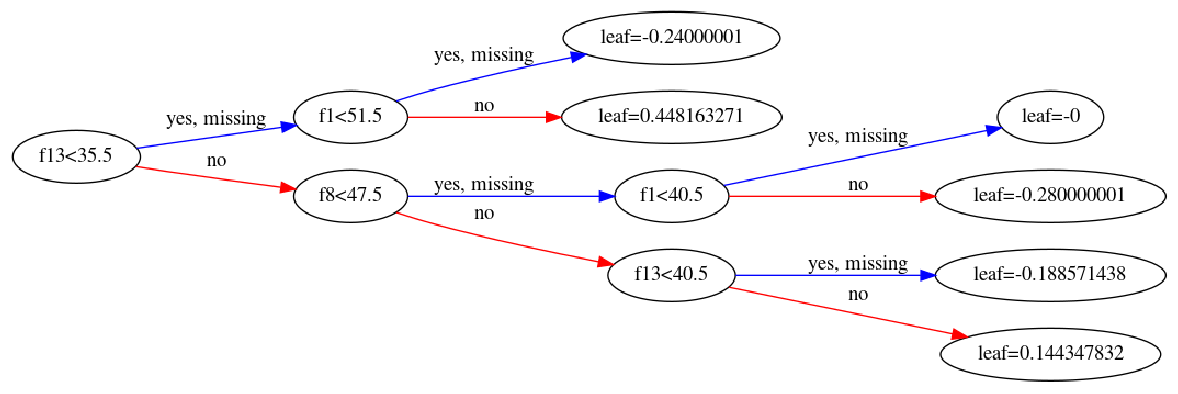

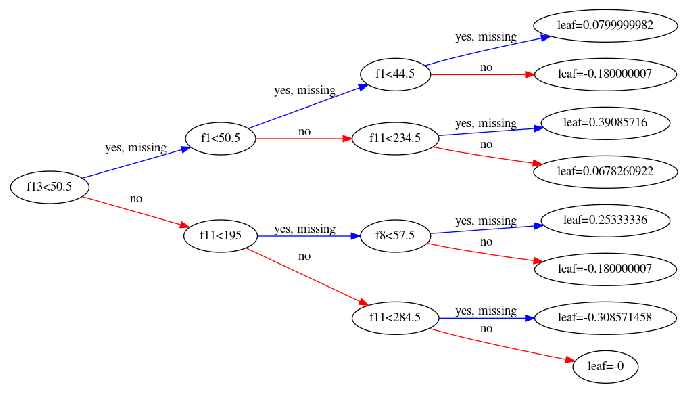

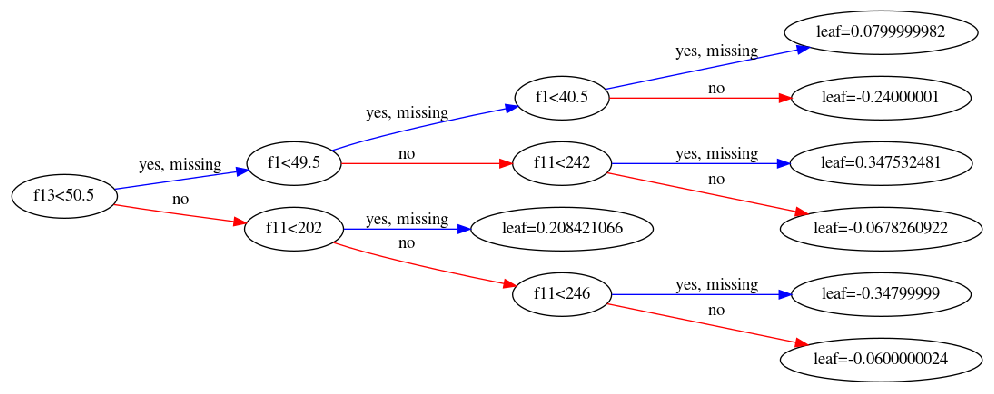

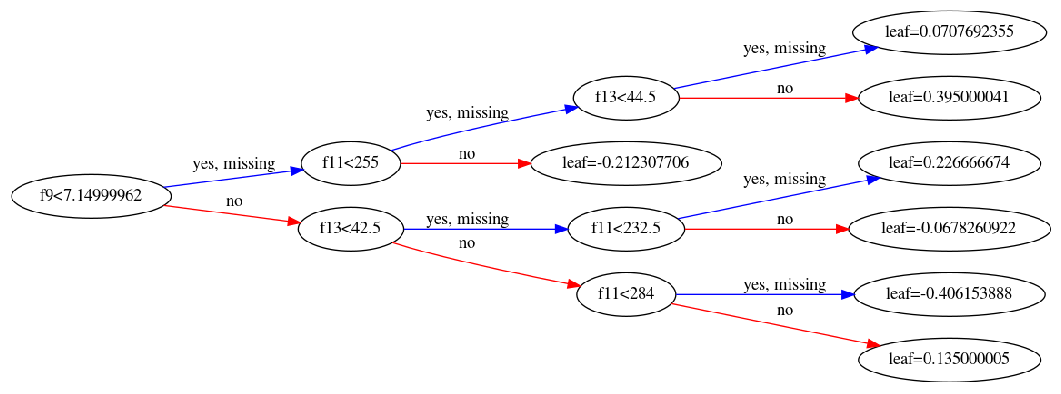

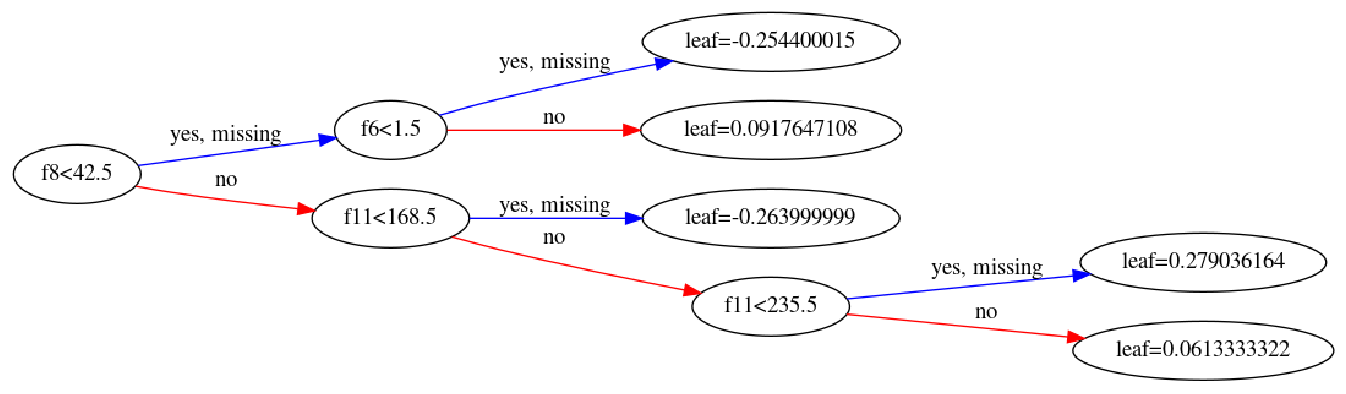

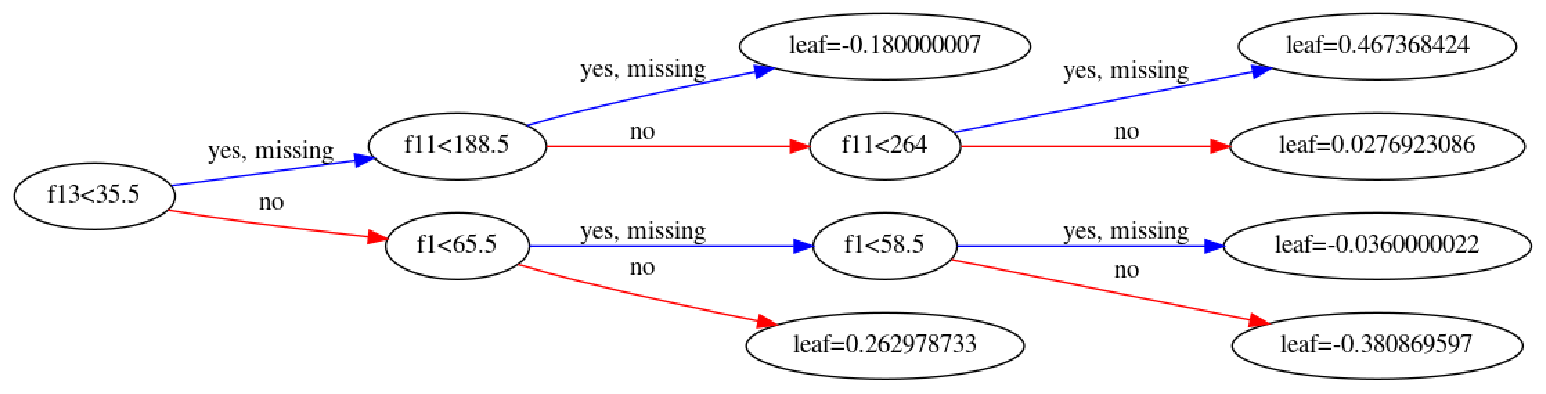

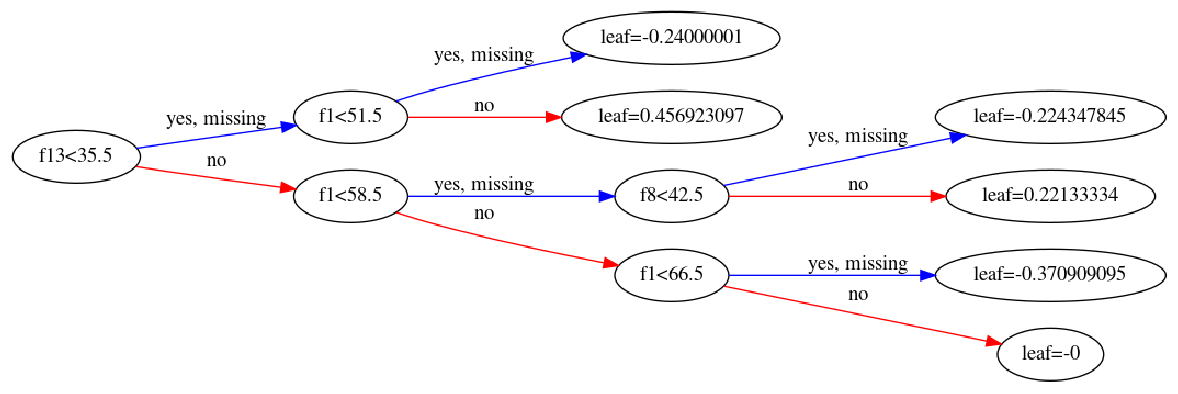

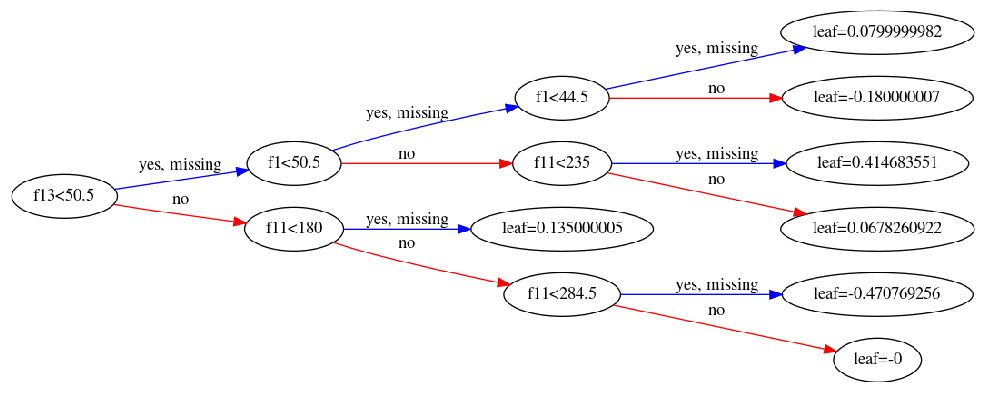

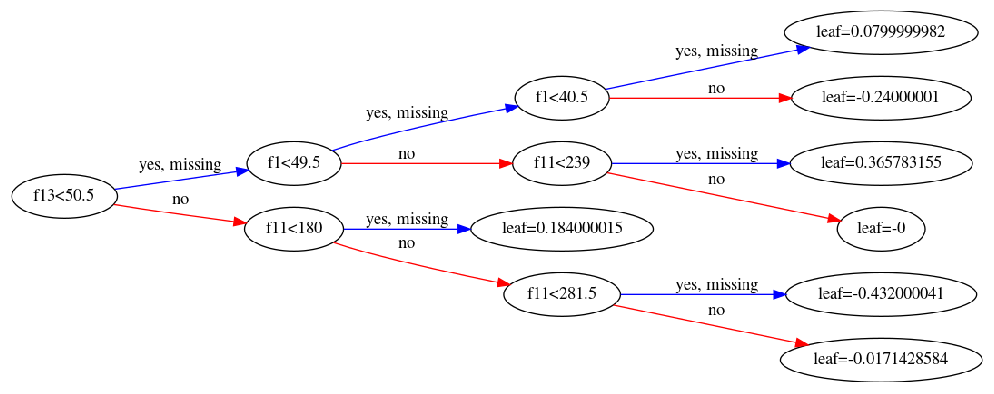

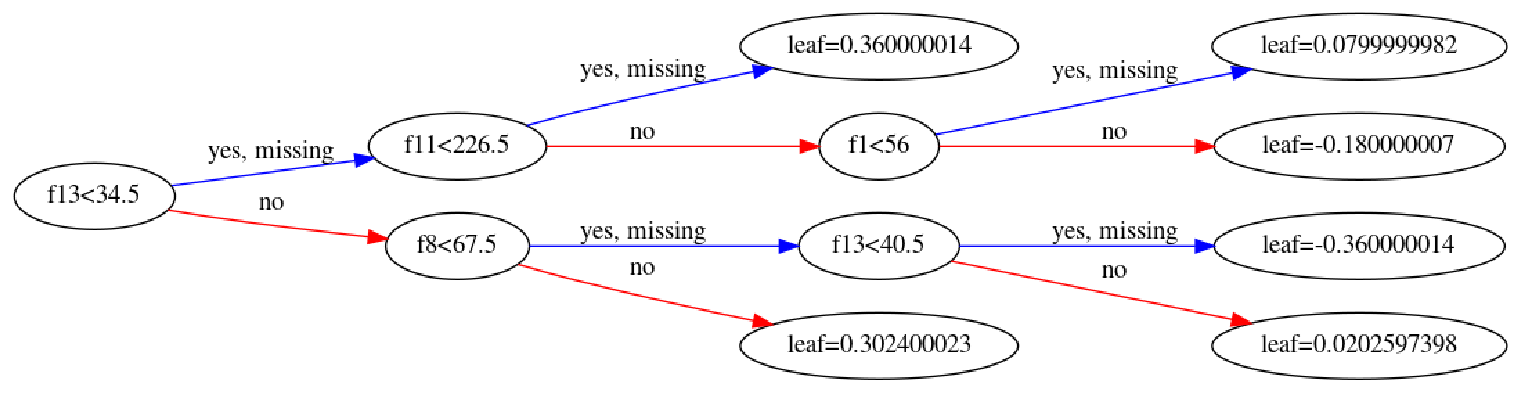

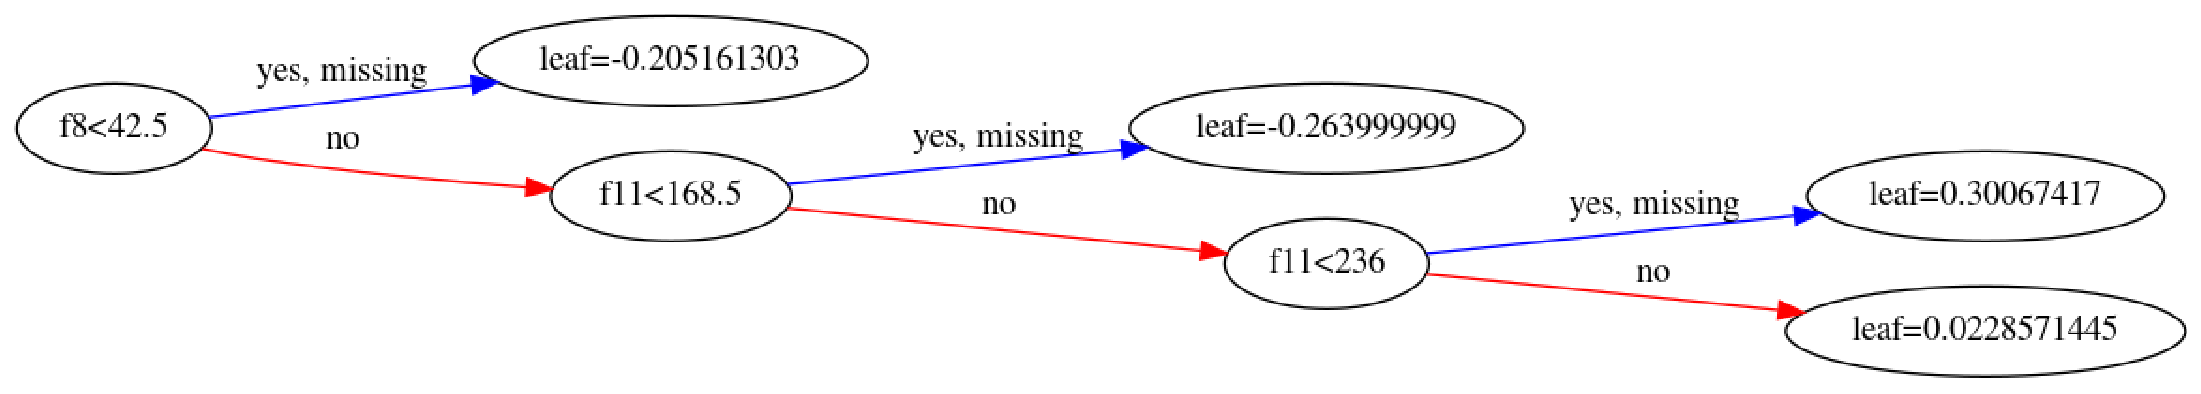

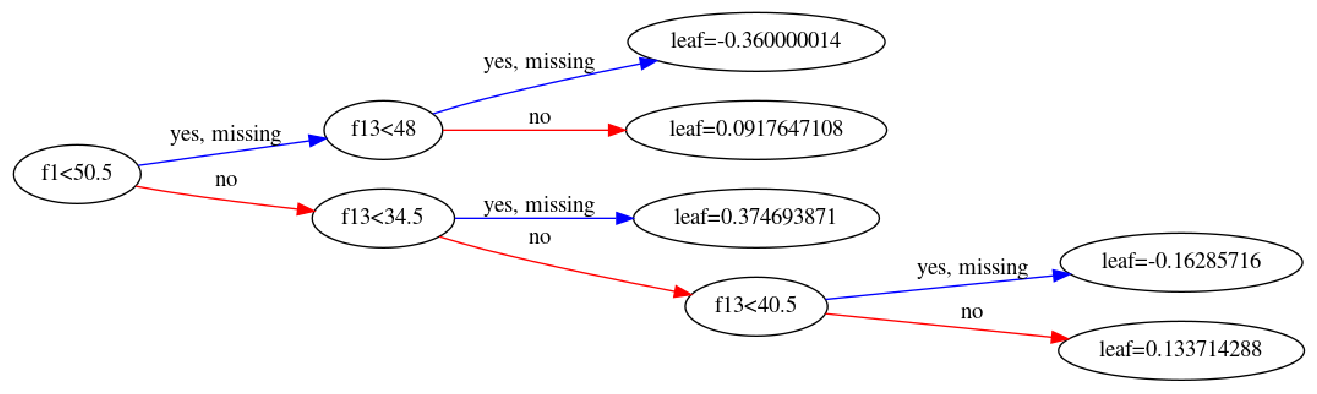

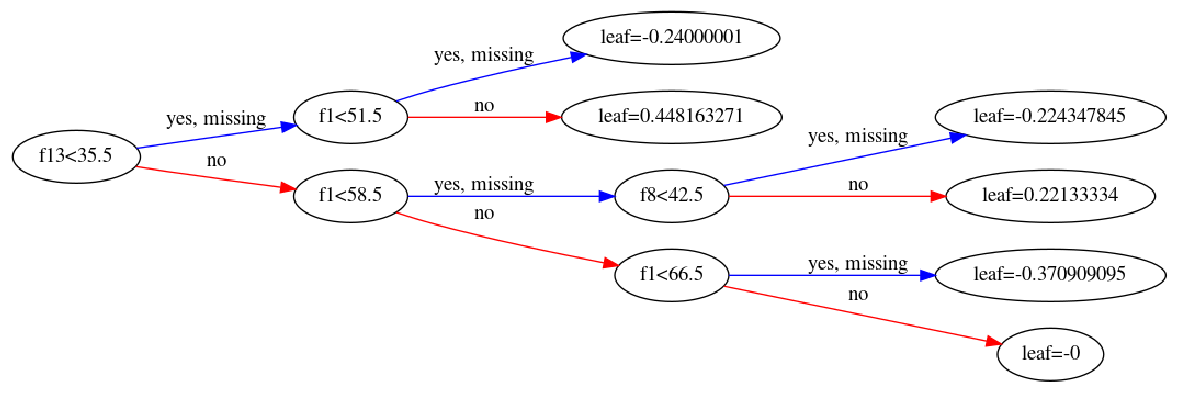

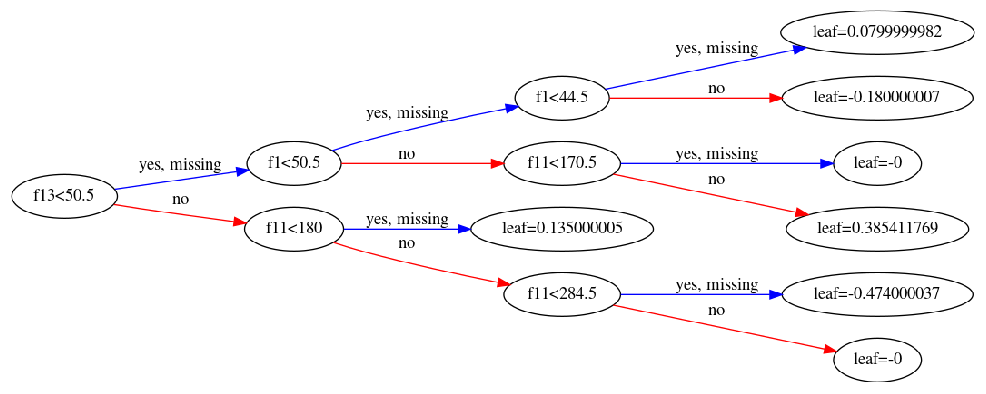

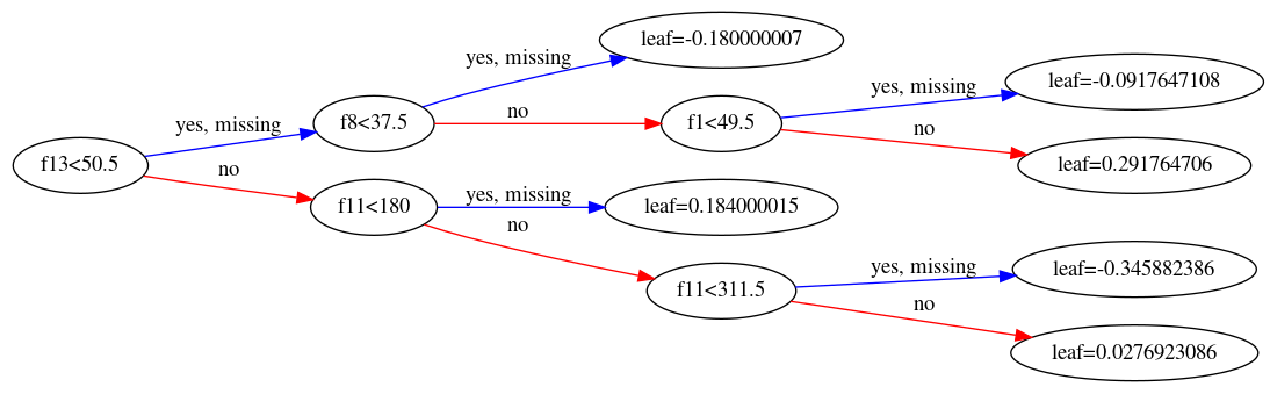

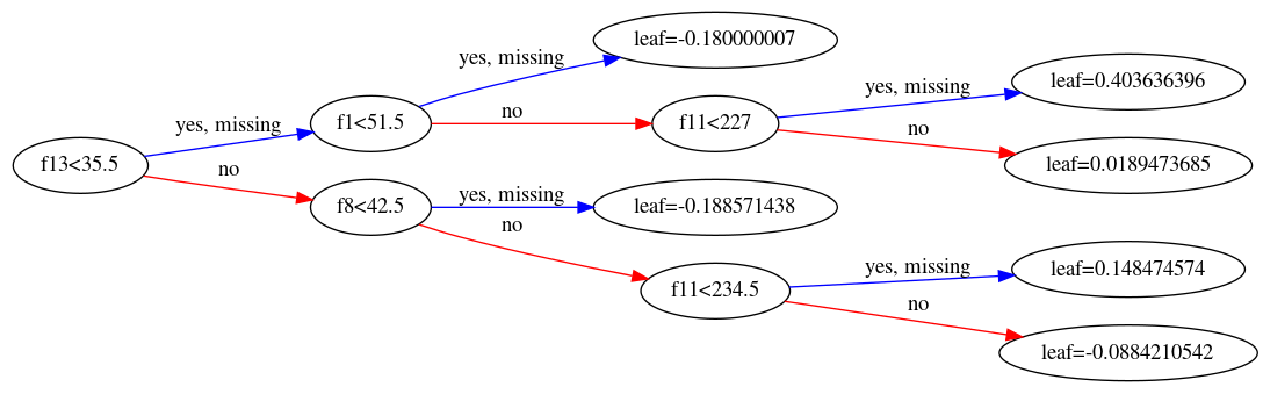

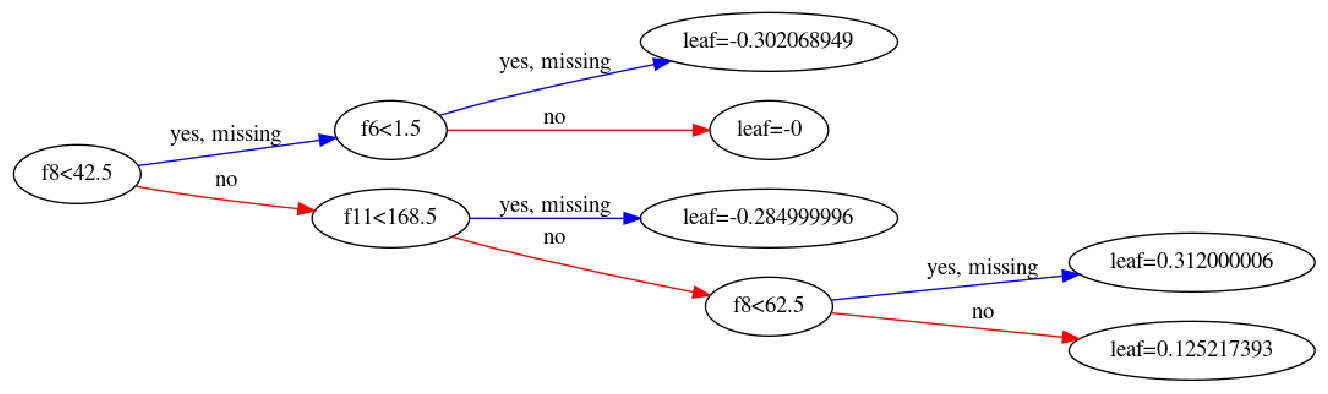

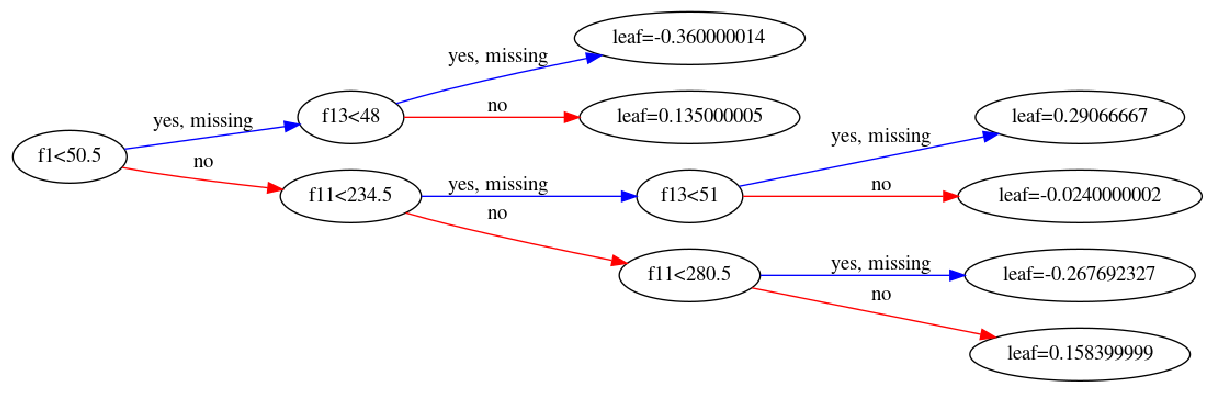

----------------------------------------------------------------
[0.3, 3, 1000, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8]
accuracy     0.725
specificity  0.7245852187028657
sensitivity  0.735
auc          0.7297926093514329
----------------------------------------------------------------


In [47]:
max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params)

In [16]:
print(max_params)
print(max_acc)
print(max_spes)
print(max_sens)
print(max_auc)

[0.3, 3, 1000, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8]
0.725
0.7245852187028657
0.735
0.7297926093514329


In [17]:
#Τυπώνονται περιπτώσεις που accuracy>0.6 και specificity>0.6 και sensitivity>0.6 και auc>0.6
s = 0
for i in range(len(best_params)):
    if best_params[i][4] > 0.68:
        print("parameters :",best_params[i][0])
        print("accuracy :",best_params[i][1])
        print("spes     :",best_params[i][2])
        print("sens     :",best_params[i][3])
        print("auc      :",best_params[i][4])
        print("------------------------------------------------")
        s+=1
print(s)

parameters : [0.3, 3, 1000, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8]
accuracy : 0.725
spes     : 0.7245852187028657
sens     : 0.735
auc      : 0.7297926093514329
------------------------------------------------
1


{'colsample_bylevel': 0.6382176728855455, 'colsample_bytree': 0.8306771142547185, 'gamma': 0.819349850033181, 'learning_rate': 0.307901339993026, 'max_depth': 3.0, 'min_child_weight': 2.0, 'reg_alpha': 0.11906947540585035, 'reg_lambda': 2.386832289382199, 'scale_pos_weight': 4.0, 'subsample': 0.8640652777168678}

In [48]:
params = {
                    "learning_rate"    :[0.307901339993026],  #0.01-0.2 Makes the model more robust by shrinking the weights on each step
                    "max_depth"        :[3],  #3-10 control over-fitting as higher depth will allow model to learn relations very specific to a particular sample
                    "n_estimators"     :[1000],
                    "min_child_weight" :[2],         #0.5-1 small values might lead to under-fitting
                    "gamma"            :[0.819349850033181],            #Makes the algorithm conservative --> No overfitting
                    "colsample_bylevel" :[0.6382176728855455], #0.5-1
                     "reg_lambda"      :[2.386832289382199], #  it should be explored to reduce overfitting.
                    "scale_pos_weight" :[4],
                    "colsample_bytree" :[0.8306771142547185],
                    "reg_alpha"        :[0.11906947540585035],
                    "subsample"        :[0.8640652777168678]
    
        }
# new features [3, 14, 13, 11, 15, 1, 2, 12, 10, 5, 6, 8, 0, 4]
# [0.3, 3, 1000, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8]
# accuracy     0.725
# specificity  0.7245852187028657
# sensitivity  0.735
# auc          0.7297926093514329

In [50]:
max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params)

1
0
[0.307901339993026, 3, 1000, 2, 0.819349850033181, 0.6382176728855455, 2.386832289382199, 4, 0.8306771142547185, 0.11906947540585035, 0.8640652777168678]
accuracy     0.6428571428571429
specificity  0.6495475113122172
sensitivity  0.57
auc          0.6097737556561086


{'colsample_bylevel': 0.7933350073259612, 'colsample_bytree': 0.5060331748489936, 'gamma': 0.9584118840631856, 'learning_rate': 0.3258784028252499, 'max_depth': 3.0, 'min_child_weight': 2.0, 'reg_alpha': 0.2144892802525658, 'reg_lambda': 2.000299798855991, 'scale_pos_weight': 3.0, 'subsample': 0.8896058012054913}

In [20]:
params = {
                    "learning_rate"    :[0.3],  #0.01-0.2 Makes the model more robust by shrinking the weights on each step
                    "max_depth"        :[3],  #3-10 control over-fitting as higher depth will allow model to learn relations very specific to a particular sample
                    "n_estimators"     :[1000],
                    "min_child_weight" :[1],         #0.5-1 small values might lead to under-fitting
                    "gamma"            :[1],            #Makes the algorithm conservative --> No overfitting
                    "colsample_bylevel" :[0.75], #0.5-1
                     "reg_lambda"      :[2], #  it should be explored to reduce overfitting.
                    "scale_pos_weight" :[3],
                    "colsample_bytree" :[0.5],
                    "reg_alpha"        :[0.2],
                    "subsample"        :[0.8],
                    "base_score"       :[0.5],
                    "colsample_bynode" :[1],
                    "max_delta_step"   :[0]
            
        }
# new features [3, 14, 13, 11, 15, 1, 2, 12, 10, 5, 6, 8, 0, 4]
# [0.3, 3, 1000, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8]
# accuracy     0.725
# specificity  0.7245852187028657
# sensitivity  0.735
# auc          0.7297926093514329

In [199]:
max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params)
#v=55

1
0
[0.6358695652173914, 0.9239130434782609, 0.7934782608695652, 0.7391304347826086, 0.7717391304347826, 0.7934782608695652]
[0.6195652173913043, 0.5489130434782609, 0.8695652173913043, 0.7717391304347826, 0.75, 0.782608695652174]
[0.9021739130434783, 0.6195652173913043, 0.47282608695652173, 0.7173913043478262, 0.7934782608695652, 0.6956521739130435]
[0.891304347826087, 0.9021739130434783, 0.6902173913043479, 0.7173913043478262, 0.8369565217391304, 0.7282608695652174]
[0.8586956521739131, 0.9782608695652174, 0.9021739130434783, 0.625, 0.5923913043478262, 0.7934782608695652]
[0.8586956521739131, 0.9673913043478262, 0.9456521739130435, 0.9565217391304348, 0.5923913043478262, 0.7717391304347826]
[0.8369565217391304, 0.9782608695652174, 0.9347826086956521, 0.9673913043478262, 0.9130434782608696, 0.7717391304347826]
[0.8804347826086957, 0.9456521739130435, 0.9347826086956521, 0.9673913043478262, 0.891304347826087, 0.782608695652174]
[0.9347826086956521, 0.9565217391304348, 0.836956521739130

In [204]:
max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params)
#v=54

1
0
----------------------------------------------------------------
[0.3, 3, 1000, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8, 0.5, 1, 0]
accuracy     0.7214285714285714
specificity  0.718815987933635
sensitivity  0.76
auc          0.7394079939668174
----------------------------------------------------------------


In [207]:
max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params)
#v=55.5

1
0
----------------------------------------------------------------
[0.3, 3, 1000, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8, 0.5, 1, 0]
accuracy     0.725
specificity  0.7226621417797888
sensitivity  0.76
auc          0.7413310708898944
----------------------------------------------------------------


In [217]:
max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params)
#v=56

1
0
----------------------------------------------------------------
[0.3, 3, 1000, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8, 0.5, 1, 0]
accuracy     0.7267857142857143
specificity  0.7245852187028657
sensitivity  0.76
auc          0.7422926093514328
----------------------------------------------------------------


In [219]:
max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params)
#v=56.5

1
0
----------------------------------------------------------------
[0.3, 3, 1000, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8, 0.5, 1, 0]
accuracy     0.7267857142857143
specificity  0.7245852187028657
sensitivity  0.76
auc          0.7422926093514328
----------------------------------------------------------------


In [221]:
max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params)
#v=57

1
0
----------------------------------------------------------------
[0.3, 3, 1000, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8, 0.5, 1, 0]
accuracy     0.7267857142857143
specificity  0.7245852187028657
sensitivity  0.76
auc          0.7422926093514328
----------------------------------------------------------------


In [227]:
max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params)
#v=57.7

1
0
----------------------------------------------------------------
[0.3, 3, 1000, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8, 0.5, 1, 0]
accuracy     0.725
specificity  0.7245852187028657
sensitivity  0.735
auc          0.7297926093514329
----------------------------------------------------------------


In [21]:
max_sens ,max_params, max_spes, max_acc, max_auc, best_params = gridsearch(params)
#v=57.6

1
0
----------------------------------------------------------------
[0.3, 3, 1000, 1, 1, 0.75, 2, 3, 0.5, 0.2, 0.8, 0.5, 1, 0]
accuracy     0.7267857142857143
specificity  0.7245852187028657
sensitivity  0.76
auc          0.7422926093514328
----------------------------------------------------------------


In [ ]:
import xgboost
import shap

# load JS visualization code to notebook
shap.initjs()

# train XGBoost model
X,y = shap.datasets.boston()
model = xgboost.train({"learning_rate": 0.01}, xgboost.DMatrix(X, label=y), 100)

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn and spark models)
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

# visualize the first prediction's explanation (use matplotlib=True to avoid Javascript)
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])